In [1]:
# %matplotlib inline
%matplotlib qt5

In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style
from mpl_toolkits.axes_grid1 import make_axes_locatable

from qick import *
from qick.helpers import gauss

import logging
logger = logging.getLogger('qick.qick_asm')
logger.setLevel(logging.ERROR)

from tqdm import tqdm_notebook as tqdm

import time
import os
expt_path=os.getcwd()+'/data'
import sys
import scipy as sp
import json

import qutip as qt
import qutip.visualization as qplt

from slab.instruments import InstrumentManager
from slab.experiment import Experiment
from slab.datamanagement import SlabFile
from slab import get_next_filename, AttrDict

# Figure params
plt.rcParams['figure.figsize'] = [10,6]
plt.rcParams.update({'font.size': 16})
# style.use('default')
style.use('S:\Connie\prx.mplstyle')

np.set_printoptions(threshold=sys.maxsize)

Could not import QickInstrument (will only work if running on rfsoc). If running on rfsoc, try install/update qick package
Warning failed to import AWG81180A
Warning failed to import Tek5014
Warning failed to import Tek70001
Warning failed to import M8195A


C:\ProgramData\Anaconda3\lib\site-packages\IPython\qt.py:12: ShimWarning: The `IPython.qt` package has been deprecated since IPython 4.0. You should import from qtconsole instead.
  warn("The `IPython.qt` package has been deprecated since IPython 4.0. "


Could not load InstrumentManagerWindow
Could not load labbrick
Could not load Autonics TM4 Driver
Could not load Oxford Trition driver


In [3]:
sys.path.append(os.getcwd()+'/../../qutip_sims')
from QSwitch import QSwitch
from PulseSequence import PulseSequence

In [4]:
# %aimport experiments
# NOTE: ADDING NEW METHODS WILL NOT BE UPDATED
import experiments as meas

imported experiments.clifford_averager_program
imported experiments.fitting
imported experiments.four_qubit.fourQ_state_tomo
imported experiments.qram_protocol_timestepped
imported experiments.single_qubit.acstarkshift_spectroscopy
imported experiments.single_qubit.amplitude_rabi
imported experiments.single_qubit.length_rabi
imported experiments.single_qubit.pulse_probe_spectroscopy
imported experiments.single_qubit.resonator_spectroscopy
imported experiments.single_qubit.rfsoc_tof_calibration
imported experiments.single_qubit.single_shot
imported experiments.single_qubit.t1
imported experiments.single_qubit.t2_ramsey
imported experiments.three_qubit.threeQ_state_tomo
imported experiments.two_qubit.amplitude_rabi_EgGf
imported experiments.two_qubit.amplitude_rabi_f0g1
imported experiments.two_qubit.amprabi_opt_ctrl_state_prep
imported experiments.two_qubit.crosstalk_echo_calib
imported experiments.two_qubit.length_rabi_EgGf
imported experiments.two_qubit.length_rabi_F0G1
imported exper

# Tomo analysis

In [4]:
from TomoAnalysis import TomoAnalysis
tomo_analysis = TomoAnalysis(nb_qubits=3)

# Getting ideal rho

Define psi basis

In [5]:
# 2 cardinal points on Bloch sphere for each measurement axis
# psiZ = [qt.basis(3,0), qt.basis(3,1)]
psiZ = [qt.basis(2,0), qt.basis(2,1)]
psiX = [1/np.sqrt(2)*(psiZ[0]+psiZ[1]), 1/np.sqrt(2)*(psiZ[0]-psiZ[1])]
psiY = [1/np.sqrt(2)*(psiZ[0]+1j*psiZ[1]), 1/np.sqrt(2)*(psiZ[0]-1j*psiZ[1])]
psi_dict = dict(Z=psiZ, X=psiX, Y=psiY)

psis = dict() # psis in the ZZZ basis
for i, label_numeric in enumerate(tomo_analysis.calib_order_numeric):
    psis.update({label_numeric:tomo_analysis.psi_basis['ZZZ'][i]})
id3q = qt.tensor(qt.qeye(2), qt.qeye(2), qt.qeye(2))
id2q = qt.tensor(qt.qeye(2), qt.qeye(2))

In [6]:
def name_to_state_2q(init_state): # in format |QA>|QB>
    Qa, Qb, _ = init_state.split('>')
    Qa = Qa[1:]
    Qb = Qb[1:]
    psi_name_dict = {
        '0':psiZ[0],
        '1':psiZ[1],
        '0+1':(psiZ[0]+psiZ[1]).unit(),
        '0-1':(psiZ[0]-psiZ[1]).unit(), 
        '0+i1':(psiZ[0]+1j*psiZ[1]).unit(), 
        '0-i1':(psiZ[0]-1j*psiZ[1]).unit(), 
    }
    try:
        psiA = psi_name_dict[Qa]
    except:
        print(f'QA state {Qa} is not an allowed cardinal state')
    try:
        psiB = psi_name_dict[Qb]
    except:
        print(f'QB state {Qb} is not an allowed cardinal state')
    return qt.tensor(psiA, psiB)

    
def get_qram_qSLR_state_from_rho(init_rho_SI, post_select=False, post_select_state=None):
    """
    init_rho_SI should be a np array
    """
    # in order |00>, |01>, |10>, |11> for Q0 (switch), Q1 (input)
    SI_to_SLR = [psis['000'], -1j*psis['010'], psis['100'], -1j*psis['101']]

    assert np.shape(init_rho_SI) == id2q.shape
    rho_final_SLR = 0*qt.ket2dm(psis['000'])
    print('constructing final state on |switch, out1, out2>')
    for i in range(len(SI_to_SLR)):
        slr_ket_i = SI_to_SLR[i]
        for j in range(len(SI_to_SLR)):
            slr_ket_j = SI_to_SLR[j]
            mat_el = init_rho_SI[i, j]
            rho_final_SLR += mat_el * slr_ket_i * slr_ket_j.dag()
    return rho_final_SLR.unit()

# Run experiment and analysis

In [7]:
"""Reopen saved data"""
def prev_data(expt_path, filename):
    temp_data_file = expt_path
    if filename is not None: temp_data_file = os.path.join(expt_path, filename)
    print(temp_data_file)
    with SlabFile(temp_data_file) as a:
        attrs = dict()
        for key in list(a.attrs):
            attrs.update({key:json.loads(a.attrs[key])})
        keys = list(a)
        temp_data = dict()
        for key in keys:
            temp_data.update({key:np.array(a[key])})
        print(f'Extracted data and attrs {list(a.attrs)}')
    return temp_data, attrs

In [8]:
data_path = 'S:\\QRAM\\qram_4QR2\\'
# expt_path=os.path.join(os.getcwd(), 'data', 'data_240617')
expt_path = os.path.join(data_path, 'data', 'data_241025')
print('Data will be stored in', expt_path)

Data will be stored in S:\QRAM\qram_4QR2\data\data_241025


In [9]:
# config_file = 'config_zcu216.yml'
# config_file = 'config_q3diamond.yml'
# config_file = 'config_q3diamond_full688_reset.yml'
config_file = 'config_q3diamond_full688and638_reset.yml'
# config_path = os.path.join(os.getcwd(), config_file)

# config_file = 'config.yml'
config_path = os.path.join('s:\\Connie\\experiments\\qram_tprocv1_expts\\configs\\', config_file)

print('Config will be', config_path)

Config will be s:\Connie\experiments\qram_tprocv1_expts\configs\config_q3diamond_full688and638_reset.yml


In [10]:
import yaml
with open(config_path, 'r') as cfg_file:
    yaml_cfg = yaml.safe_load(cfg_file)
yaml_cfg = AttrDict(yaml_cfg)

In [11]:
import Pyro4.util

## Setup experiment hardware

Set in config:
- LO alias, frequency, power
- SOC dac channels, nyquist zones

In [12]:
# im = InstrumentManager(ns_address='192.168.14.1') # Chicago lab
# im = InstrumentManager(ns_address='192.168.137.1') # SLAC lab
# im = InstrumentManager(ns_address='10.108.30.56') # Spilker Fermium
im = InstrumentManager(ns_address='10.108.30.75') # Spilker Vibranium
print(im.keys())

dict_keys(['Pyro.NameServer', 'Qick_QRAM'])


In [13]:
soc = QickConfig(im[yaml_cfg['aliases']['soc']].get_cfg())
print(soc)
# print(soc.description())
# print(soc.dump_cfg())

QICK running on ZCU216, software version 0.2.272

Firmware configuration (built Sat Oct  5 10:21:47 2024):

	Global clocks (MHz): tProcessor 430.080, RF reference 245.760

	7 signal generator channels:
	0:	axis_signal_gen_v6 - envelope memory 32768 samples (5.128 us)
		fs=6389.760 MHz, fabric=399.360 MHz, 32-bit DDS, range=6389.760 MHz
		DAC tile 2, blk 0 is 0_230, on JHC3
	1:	axis_signal_gen_v6 - envelope memory 32768 samples (5.128 us)
		fs=6389.760 MHz, fabric=399.360 MHz, 32-bit DDS, range=6389.760 MHz
		DAC tile 2, blk 1 is 1_230, on JHC4
	2:	axis_signal_gen_v6 - envelope memory 32768 samples (5.128 us)
		fs=6389.760 MHz, fabric=399.360 MHz, 32-bit DDS, range=6389.760 MHz
		DAC tile 2, blk 2 is 2_230, on JHC3
	3:	axis_signal_gen_v6 - envelope memory 32768 samples (5.128 us)
		fs=6389.760 MHz, fabric=399.360 MHz, 32-bit DDS, range=6389.760 MHz
		DAC tile 2, blk 3 is 3_230, on JHC4
	4:	axis_signal_gen_v6 - envelope memory 32768 samples (4.762 us)
		fs=6881.280 MHz, fabric=430.080 MH

In [ ]:
lo1 = im[yaml_cfg.aliases.readout_LO]
lo1.open_device()
print(lo1.get_id())

# TURN OFF
lo1.set_standby(True)
lo1.set_output_state(False)

# # TURN ON
# lo1.set_standby(False)
# lo1.set_output_state(True)
# lo_freq = float(yaml_cfg.hw.lo.readout.frequency)
# lo_power = float(yaml_cfg.hw.lo.readout.power)
# lo1.set_frequency(lo_freq) # Set LO frequency
# print('set freq to', lo_freq)
# lo1.set_power(lo_power) # Set LO power
# print('set power to', lo_power)

## Run experiment and acquire data

### Test 3Q tomo

In [ ]:
save_data = True
saved_files = []

In [ ]:
tomo_qubits = [0, 2, 3] # which qubit/resonator we want to probe

In [ ]:
tomoExpt = meas.TestStateTomo3QExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"test_3q_state_tomo_{tomo_qubits[0]}{tomo_qubits[1]}{tomo_qubits[2]}",
    config_file=config_path,
)

tomoExpt.cfg.expt = dict(
    reps=20000, # reps per measurement basis
    singleshot_reps=30000, # reps for single shot calib
    tomo_qubits=tomo_qubits,
)

print(tomoExpt.cfg)
import Pyro4.util
try:
    tomoExpt.go(analyze=False, display=False, progress=True, save=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

if save_data: saved_files.append(tomoExpt.save_data())

In [ ]:
tomo = tomoExpt
# tomo = qramExpt

# data, attrs = prev_data(expt_path, '00062_qram_protocol.h5')
# pulse_dict = attrs['pulse_dict']
# assert np.all(np.array(attrs['meas_order']) == meas_order)
# assert np.all(np.array(attrs['calib_order']) == calib_order)

print(meas_order)
print(calib_order)

data = tomo.data
pulse_dict = tomo.pulse_dict
assert np.all(np.array(tomo.meas_order) == tomo_analysis.meas_order)
assert np.all(np.array(tomo.calib_order) == tomo_analysis.calib_order)

n_tomo_raw = np.array(data['counts_tomo'])
n_calib = np.array(data['counts_calib'])

np.set_printoptions(suppress=True)
print('Tomography counts')
print(n_tomo_raw)
print('Confusion matrix counts')
print(n_calib)
print('Confusion matrix corrected tomo matrix will be')
print(tomo_analysis.correct_readout_err(n_tomo_raw, n_calib))
# print('Negative counts corrected tomo matrix will be')
# print(tomo_analysis.fix_neg_counts(correct_readout_err(n_tomo_raw, n_calib)))

### Qram experiment

In [14]:
tomo_qubits = [0, 2, 3] # which qubit/resonators to do tomo on
# tomo_qubits = [0, 1, 2] # which qubit/resonators to do tomo on

In [146]:
save_data = False
saved_files = []

In [147]:
init_state = '|1>|1>' # Q0/Q1 (switch, input)
# init_state = 'Q3Q0_|1>|1>'
# init_state = '|0>|1>' # Q0/Q1 (switch, input)
# init_state = 'Q2Q0_|1>|0>'

# play_pulses = [0] # 1: Q2/Q1 with Q0 in g, 2: Q3/Q1 with Q0 in e, 3: Q2 ef pulse, 4: Q3 ef pulse [2, 1, 4, 3]
# play_pulses = [2, 1, 4, 3] # 1: Q2/Q1 with Q0 in g, 2: Q3/Q1 with Q0 in e, 3: Q2 ef pulse, 4: Q3 ef pulse [2, 1, 4, 3]
# play_pulses = [1, 3] # 1: Q2/Q1 with Q0 in g, 2: Q3/Q1 with Q0 in e, 3: Q2 ef pulse, 4: Q3 ef pulse [2, 1, 4, 3]
play_pulses = [2, 4] # 1: Q2/Q1 with Q0 in g, 2: Q3/Q1 with Q0 in e, 3: Q2 ef pulse, 4: Q3 ef pulse [2, 1, 4, 3]

# cool_qubits = [0, 1]
cool_qubits = None
readout_cool = True

sync_between_swaps = False

In [151]:
qramExpt = meas.QramProtocol3QTomoExperiment(
    soccfg=soc,
    path=expt_path,
    config_file=config_path,
)

# span = 2.161196963262976 # total time [us]
# span = 1.1659462011134218 # total time [us]
span = np.inf
npts = 1
# span = 1.8 # total time [us]
# npts = 120
# span = 0.8 # total time [us]
# npts = 10
if span < np.inf: print('time step size [cycles]:', soc.us2cycles(span/npts))

qramExpt.cfg.expt = dict(
    # start=0, # start protocol time [us],
    # step=span/npts, # time step [us], 
    # expts=npts+1, # number of different time experiments - added 1 to include 0 step and full span

    start=span,
    step=0,
    expts=1, # number of different time experiments

    reps=40000, # number of reps per tomo/time step,
    # reps=1000,
    # singleshot_reps=1, # reps per state for singleshot calibration
    singleshot_reps=40000, # reps per state for singleshot calibration
    # singleshot_reps=1000, # reps per state for singleshot calibration
    # singleshot_reps=200,
    post_process='scale', # 'threshold', (uses single shot binning), 'scale' (scale by ge_avgs), or None
    tomo_3q=True, # flag to perform tomo on last time step
    tomo_qubits=tomo_qubits, # the qubits on which to do the 3q state tomo
    init_state=init_state,
    play_pulses=play_pulses, # [2, 1, 4, 3]
    sync_between_swaps=sync_between_swaps,
    
    cool_qubits=cool_qubits,
    
    use_IQ_pulse=True,
    plot_IQ=False,
    
    readout_cool=readout_cool,
    n_init_readout=1,
    n_trig=1,
    # init_read_wait_us=5,
    init_read_wait_us=10,
)

# print(qramExpt.cfg)

import Pyro4.util
try:
    qramExpt.acquire(debug=False, progress=True)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

# tomo = qramExpt
# data = tomo.data
# n_tomo_raw = np.array(data['counts_tomo'])
# n_calib = np.array(data['counts_calib'])

# n_tomo_raw_rounds.append(n_tomo_raw)
# n_calib_rounds.append(n_calib)
# n_tomo_rounds.append(fix_neg_counts(correct_readout_err(n_tomo_raw, n_calib)))


timesteps [inf]


  0%|          | 0/8 [00:00<?, ?it/s]

Qubit  (0)
ge fidelity (%): 76.60441511037776 	 angle (deg): 140.55899339846783 	 threshold ge: 284.51550785954527
Qubit  (2)
ge fidelity (%): 84.58 	 angle (deg): 52.89868536832795 	 threshold ge: 538.2860367490651
Qubit  (3)
ge fidelity (%): 73.9225 	 angle (deg): 173.4203831027385 	 threshold ge: 26.988901198562814


  0%|          | 0/2 [00:00<?, ?it/s]

Qubit (1) ge
ge fidelity (%): 62.9625 	 angle (deg): -123.57940234048294 	 threshold ge: 416.8220225350385
thresholds=[284.51550785954527, 416.8220225350385, 538.2860367490651, 26.988901198562814],
angles=[140.55899339846783, -123.57940234048294, 52.89868536832795, 173.4203831027385],
ge_avgs=[[29.459903477647575, -230.2573427951389, -266.3916949598524, -474.4991655327691], [-274.1096103597005, 168.75457174479166, -415.16107898763016, 379.8161561767578], [253.20678680013023, -173.05187026367187, 552.7167545410156, -567.4684443847656], [143.36151903889973, -472.10610014241536, -203.39124490966796, -513.3567428548176]] ,
counts_calib=[[31537, 2879, 2072, 201, 2754, 281, 217, 59], [6002, 28507, 461, 1790, 520, 2483, 51, 186], [3039, 301, 30941, 2617, 258, 33, 2532, 279], [668, 2740, 6357, 27033, 62, 260, 614, 2266], [5057, 573, 347, 74, 29113, 2563, 2022, 251], [925, 4973, 76, 351, 4969, 26487, 368, 1851], [537, 45, 5133, 443, 2830, 249, 28533, 2230], [141, 500, 1108, 4687, 603, 2631, 579

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

In [152]:
saved_files = [qramExpt.save_data()]

Saving S:\Connie\experiments\qramLL_4QR2\data\data_240617\00052_QramProtocol3QTomo.h5
S:\Connie\experiments\qramLL_4QR2\data\data_240617\00052_QramProtocol3QTomo.h5


#### post processing counts

In [153]:
apply_ps = True
ps_adjust = [-0.3, -1.0, -0.3, -0.3]
# ps_adjust = [np.inf]*4
ps_qubits = [0, 1, 2, 3]

In [76]:
tomo = qramExpt
data = tomo.data
cfg = tomo.cfg
pulse_dict = qramExpt.pulse_dict
init_state = qramExpt.cfg.expt.init_state

n_tomo_raw, n_calib = tomo_analysis.n_tomo_calib_from_data(data, cfg, ps_adjust=ps_adjust, ps_qubits=ps_qubits, apply_ps=apply_ps, verbose=True)

print('calib order', tomo_analysis.calib_order)

print('Raw tomography counts')
print(n_tomo_raw)
print('Confusion matrix counts')
print(n_calib)
print('Confusion matrix corrected tomo matrix will be')
print(tomo_analysis.correct_readout_err(n_tomo_raw, n_calib))
# print('Negative counts corrected tomo matrix will be')
# print(tomo_analysis.fix_neg_counts(correct_readout_err(n_tomo_raw, n_calib))) 

calib order ['ggg' 'gge' 'geg' 'gee' 'egg' 'ege' 'eeg' 'eee']
Raw tomography counts
[[ 7306  4993 55883  1575  1649  2116  1260   218]
 [ 4958  7410 32271 25028   961  2876   776   720]
 [ 4936  7524 32736 25027  1916  1433   792   636]
 [29807  3179 35574  1918  1276   989  1428   829]
 [16484 16151 22400 14995   763  1659  1034  1514]
 [17379 15317 21659 15833  1343  1021  1498   950]
 [29969  3196 35609  1741  1258   958  1455   814]
 [16949 15911 21626 15043   818  1802  1127  1724]
 [16261 16171 22196 14650  1448  1257  1772  1245]
 [ 4859  3932 30540   990  4392  3260 26137   890]
 [ 3282  5702 18373 13432  2797  4663 15335 11416]
 [ 4137  5012 18175 13330  3390  4279 15478 11199]
 [16648  2409 20312  1626 13874  1925 16931  1275]
 [ 9511  9730 13139  8975  7773  7950 10603  7319]
 [10600  8501 12793  8963  8839  7152 10690  7462]
 [16324  2339 20382  1607 14063  1900 17135  1250]
 [ 9184  9303 13046  8950  7951  8021 10924  7621]
 [ 9888  9101 13734  8467  8151  7496 11176  6987

NameError: name 'correct_readout_err' is not defined

In [139]:
filename = saved_files[-1]

IndexError: list index out of range

### Import optimal control pulse

In [ ]:
pulse_filepath = os.path.join(os.getcwd(), '240528_pulse_sequence_pp.npz')
pulse_params_dict = dict() # open file
with np.load(pulse_filepath) as npzfile:
    for key in npzfile.keys():
        pulse_params_dict.update({key:npzfile[key]})

print(pulse_params_dict.keys())
IQ_qubits = [0, 1]
print('IQ_qubits', IQ_qubits)

times = pulse_params_dict['times']
I_0 = pulse_params_dict['I_0']
Q_0 = pulse_params_dict['Q_0']
I_1 = pulse_params_dict['I_1']
Q_1 = pulse_params_dict['Q_1']
plt.figure()
plt.plot(times*1e6, I_0*1e-6, label='$I_0$')
plt.plot(times*1e6, Q_0*1e-6, label='$Q_0$')
plt.plot(times*1e6, I_1*1e-6, label='$I_1$')
plt.plot(times*1e6, Q_1*1e-6, label='$Q_1$')
plt.legend()
plt.xlabel('Times [us]')
plt.ylabel('Amplitude [MHz]')
plt.show()

I_values_MHz = np.array([I_0, I_1])*1e-6
Q_values_MHz = np.array([Q_0, Q_1])*1e-6
times_us = times*1e6

### Big qram protocol loop!

In [103]:
init_states = ['|0+1>|0>', '|0>|0+1>', '|1>|0+1>', '|0+1>|1>', '|0+1>|0+1>', '|0>|0>', '|1>|0>', '|1>|1>', '|0>|1>']
# init_states = ['|0+1>|0>', '|0>|0+1>', '|1>|0+1>', '|0+1>|1>', '|0+1>|0+1>']
# init_states = ['|0+1>|0>', '|0>|0+1>', '|1>|0+1>', '|0+1>|1>']
# init_states = ['|0+1>|0+1>']
protocol_play = [2, 1, 4, 3] # 1: Q2/Q1 with Q0 in g, 2: Q3/Q1 with Q0 in e, 3: Q2 ef pulse, 4: Q3 ef pulse [2, 1, 4, 3]

sync_between_swaps = False
sync_between_efs = False

tomo_qubits = [0, 2, 3] # which qubit/resonators to do tomo on
save_data = True
saved_files = []
# cool_qubits = [0, 1]
cool_qubits = None

readout_cool = False

use_IQ_pulse = False # state transfer IQ pulses for the state prep
use_robust_pulses = True # use robust pulses for state prep + tomo

print('init_states', init_states)
print('protocol_play', protocol_play)
print('sync between swaps', sync_between_swaps)
print('sync between efs', sync_between_efs)
print('readout cool', readout_cool)
print('use robust pulses', use_robust_pulses)
print('save data', save_data)
if not save_data:
    print('WARNING!! YOU ARE NOT SAVING DATA!')

init_states ['|0+1>|0>', '|0>|0+1>', '|1>|0+1>', '|0+1>|1>', '|0+1>|0+1>', '|0>|0>', '|1>|0>', '|1>|1>', '|0>|1>']
protocol_play [2, 1, 4, 3]
sync between swaps False
sync between efs False
readout cool False
use robust pulses True
save data True


In [104]:
play_pulses = protocol_play
for init_state in init_states:
    qramExpt = meas.QramProtocol3QTomoExperiment(
        soccfg=soc,
        path=expt_path,
        config_file=config_path,
    )
    print('init_state', init_state, 'play pulses', play_pulses)
    
    span = np.inf
    npts = 1
    if span < np.inf: print('time step size [cycles]:', soc.us2cycles(span/npts))
    
    qramExpt.cfg.expt = dict(
        start=span,
        step=0,
        expts=1, # number of different time experiments
    
        reps=75000, # number of reps per tomo/time step,
        singleshot_reps=75000, # reps per state for singleshot calibration
        # reps=100, # number of reps per tomo/time step,
        # singleshot_reps=100, #000, # reps per state for singleshot calibration
        post_process=None, # 'threshold', (uses single shot binning), 'scale' (scale by ge_avgs), or None
        tomo_3q=True, # flag to perform tomo on last time step
        tomo_qubits=tomo_qubits, # the qubits on which to do the 3q state tomo
        init_state=init_state,
        play_pulses=play_pulses, # [2, 1, 4, 3]
        cool_qubits=cool_qubits,
        sync_between_swaps=sync_between_swaps,
        sync_between_efs=sync_between_efs,
        
        use_IQ_pulse=use_IQ_pulse, # state transfer IQ pulses for the state prep
        use_robust_pulses=use_robust_pulses, # use robust pulses for state prep + tomo
        plot_IQ=False,
        
        readout_cool=readout_cool,
        n_init_readout=1,
        n_trig=1,
        init_read_wait_us=10,
    )
    
    try:
        qramExpt.acquire(progress=True, debug=False)
        success = True
    except Exception:
        print("Pyro traceback:")
        print("".join(Pyro4.util.getPyroTraceback()))
        
    if save_data: saved_files.append(qramExpt.save_data())

init_state |0+1>|0> play pulses [2, 1, 4, 3]
timesteps [inf]


  0%|          | 0/8 [00:00<?, ?it/s]

Qubit  (0)
ge fidelity (%): 80.60720404802699 	 angle (deg): -147.0987805498638 	 threshold ge: 469.6828742159774
Qubit  (2)
ge fidelity (%): 87.81866666666667 	 angle (deg): -22.544103628748555 	 threshold ge: 677.3707193965721
Qubit  (3)
ge fidelity (%): 79.8431989546597 	 angle (deg): -70.6001629438971 	 threshold ge: 1203.4480951595444
thresholds=[469.6828742159774, 0, 677.3707193965721, 1203.4480951595444],
angles=[-147.0987805498638, 0, -22.544103628748555, -70.6001629438971],
ge_avgs=[[-270.55163525236867, 65.07192529888029, -639.440152192937, 303.7277465633075], [0, 0, 0, 0], [140.08422284784376, 658.8267772931923, 754.1059857553565, 913.7168343585569], [508.54817427882284, 838.6173517607332, 695.006339469368, 1368.098816391703]] ,
counts_calib=[[60766, 5517, 2911, 305, 4593, 547, 258, 103], [7806, 58470, 381, 3044, 524, 4463, 20, 292], [4895, 383, 59174, 5346, 313, 30, 4276, 583], [728, 4137, 7056, 57788, 53, 298, 467, 4473], [7911, 723, 422, 42, 57043, 5406, 3026, 427], [1931

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Saving S:\QRAM\qram_4QR2\data\data_241025\00018_QramProtocol3QTomo.h5
init_state |0>|0+1> play pulses [2, 1, 4, 3]
timesteps [inf]


  0%|          | 0/8 [00:00<?, ?it/s]

Qubit  (0)
ge fidelity (%): 77.44318295455302 	 angle (deg): -157.96886728300765 	 threshold ge: 462.86480420384567
Qubit  (2)
ge fidelity (%): 87.84058560390403 	 angle (deg): -12.482051104127784 	 threshold ge: 666.6107241532571
Qubit  (3)
ge fidelity (%): 79.2378615857439 	 angle (deg): -81.14324326224452 	 threshold ge: 1193.039385683614
thresholds=[462.86480420384567, 0, 666.6107241532571, 1193.039385683614],
angles=[-157.96886728300765, 0, -12.482051104127784, -81.14324326224452],
ge_avgs=[[-286.616468630491, 16.676338446167097, -676.1544235658915, 174.3061561205857], [0, 0, 0, 0], [254.34698086248983, 613.5554889503662, 902.7536343368591, 757.0906901437482], [347.08614614568256, 907.8442209068982, 432.90599021707675, 1458.5974950217076]] ,
counts_calib=[[58734, 5462, 2918, 314, 6379, 703, 354, 136], [7915, 56546, 380, 3030, 722, 5975, 38, 394], [4596, 370, 57384, 5407, 497, 44, 5903, 799], [957, 3977, 7883, 54495, 87, 396, 770, 6435], [8241, 760, 413, 55, 56236, 5618, 3135, 542]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Saving S:\QRAM\qram_4QR2\data\data_241025\00019_QramProtocol3QTomo.h5
init_state |1>|0+1> play pulses [2, 1, 4, 3]
timesteps [inf]


  0%|          | 0/8 [00:00<?, ?it/s]

Qubit  (0)
ge fidelity (%): 78.26452176347843 	 angle (deg): -168.8066071246901 	 threshold ge: 476.0006973701313
Qubit  (2)
ge fidelity (%): 88.15466666666667 	 angle (deg): -1.5399367770816694 	 threshold ge: 678.428307510556
Qubit  (3)
ge fidelity (%): 77.03384689231262 	 angle (deg): -91.77707857272024 	 threshold ge: 1174.285511765288
thresholds=[476.0006973701313, 0, 678.428307510556, 1174.285511765288],
angles=[-168.8066071246901, 0, -1.5399367770816694, -91.77707857272024],
ge_avgs=[[-285.8198936571921, -37.49347580361757, -700.6872759689923, 44.602762570198095], [0, 0, 0, 0], [362.0808247138595, 547.4686449471114, 1023.7192319175482, 565.2557617792244], [161.44761391220456, 943.2917824698504, 144.67698493970093, 1483.8295705643995]] ,
counts_calib=[[59266, 5807, 2513, 304, 5972, 742, 277, 119], [9108, 55486, 319, 2588, 797, 6198, 46, 458], [4802, 399, 57364, 5733, 453, 52, 5447, 750], [1283, 4320, 8277, 54333, 96, 425, 722, 5544], [8045, 777, 341, 40, 56645, 5996, 2667, 489], 

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Saving S:\QRAM\qram_4QR2\data\data_241025\00020_QramProtocol3QTomo.h5
init_state |0+1>|1> play pulses [2, 1, 4, 3]
timesteps [inf]


  0%|          | 0/8 [00:00<?, ?it/s]

Qubit  (0)
ge fidelity (%): 78.96133333333333 	 angle (deg): -179.25868709394945 	 threshold ge: 457.51927232428636
Qubit  (2)
ge fidelity (%): 87.024 	 angle (deg): 8.375054881603456 	 threshold ge: 648.4624318602035
Qubit  (3)
ge fidelity (%): 73.95466666666667 	 angle (deg): -102.28088243186558 	 threshold ge: 1157.9231009484906
thresholds=[457.51927232428636, 0, 648.4624318602035, 1157.9231009484906],
angles=[-179.25868709394945, 0, 8.375054881603456, -102.28088243186558],
ge_avgs=[[-263.6719428975021, -91.78920119896641, -685.9185812988803, -86.32572111627908], [0, 0, 0, 0], [441.72913014374825, 450.91385881204235, 1068.2871831733116, 358.67053293192293], [-4.263024003859141, 930.191772233478, -116.24738847081525, 1444.623055716353]] ,
counts_calib=[[58806, 5842, 3055, 379, 5817, 699, 299, 103], [11055, 53262, 506, 3086, 890, 5656, 65, 480], [5085, 385, 56533, 5895, 479, 47, 5806, 770], [1458, 3827, 10109, 52586, 99, 419, 869, 5633], [7734, 656, 477, 50, 56051, 6041, 3402, 589], [

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Saving S:\QRAM\qram_4QR2\data\data_241025\00021_QramProtocol3QTomo.h5
init_state |0+1>|0+1> play pulses [2, 1, 4, 3]
timesteps [inf]


  0%|          | 0/8 [00:00<?, ?it/s]

Qubit  (0)
ge fidelity (%): 76.56266666666667 	 angle (deg): 170.52388106041758 	 threshold ge: 446.2406823561515
Qubit  (2)
ge fidelity (%): 86.66533333333334 	 angle (deg): 19.876307502638806 	 threshold ge: 626.0298377439609
Qubit  (3)
ge fidelity (%): 71.31066666666666 	 angle (deg): -112.99708176620169 	 threshold ge: 1116.2594375007964
thresholds=[446.2406823561515, 0, 626.0298377439609, 1116.2594375007964],
angles=[170.52388106041758, 0, 19.876307502638806, -112.99708176620169],
ge_avgs=[[-233.5680171989664, -140.82664396899227, -634.0984958070629, -207.6808538983635], [0, 0, 0, 0], [506.02772888527255, 355.9720720260375, 1093.9516818443178, 143.42150235964198], [-170.9357562180415, 888.3240479594788, -370.3336374529667, 1358.142547679691]] ,
counts_calib=[[57567, 6968, 3004, 482, 5663, 866, 302, 148], [11617, 52766, 519, 3199, 935, 5461, 60, 443], [5153, 485, 55635, 6911, 442, 55, 5425, 894], [1467, 4020, 9883, 52719, 95, 415, 816, 5585], [8990, 999, 570, 102, 53323, 7005, 3365

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Saving S:\QRAM\qram_4QR2\data\data_241025\00022_QramProtocol3QTomo.h5
init_state |0>|0> play pulses [2, 1, 4, 3]
timesteps [inf]


  0%|          | 0/8 [00:00<?, ?it/s]

Qubit  (0)
ge fidelity (%): 77.444 	 angle (deg): 157.8785753319289 	 threshold ge: 452.5291040895389
Qubit  (2)
ge fidelity (%): 86.88724591497277 	 angle (deg): 30.977247440110744 	 threshold ge: 640.9464425196146
Qubit  (3)
ge fidelity (%): 75.15250101667344 	 angle (deg): -123.55857141596418 	 threshold ge: 1142.7017121782242
thresholds=[452.5291040895389, 0, 640.9464425196146, 1142.7017121782242],
angles=[157.8785753319289, 0, 30.977247440110744, -123.55857141596418],
ge_avgs=[[-208.35232203273043, -178.4789991593454, -592.249841081826, -334.5308623944875], [0, 0, 0, 0], [571.3551938269595, 250.96747291564955, 1114.928862630865, -75.35081973420125], [-340.6368956102267, 859.0510616111916, -636.065772638688, 1304.4055617848526]] ,
counts_calib=[[58358, 6302, 2937, 419, 5718, 793, 327, 146], [9720, 55141, 402, 2990, 832, 5467, 42, 406], [5133, 472, 56446, 6206, 416, 46, 5410, 871], [1626, 4250, 9381, 53005, 98, 451, 805, 5384], [8535, 911, 451, 67, 54819, 6514, 3099, 604], [2494, 95

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Saving S:\QRAM\qram_4QR2\data\data_241025\00023_QramProtocol3QTomo.h5
init_state |1>|0> play pulses [2, 1, 4, 3]
timesteps [inf]


  0%|          | 0/8 [00:00<?, ?it/s]

Qubit  (0)
ge fidelity (%): 76.99517996786646 	 angle (deg): 148.2277993545072 	 threshold ge: 455.9408866725124
Qubit  (2)
ge fidelity (%): 87.28533333333334 	 angle (deg): 41.64011979587193 	 threshold ge: 660.6680223356528
Qubit  (3)
ge fidelity (%): 76.75866666666667 	 angle (deg): -134.42395176338198 	 threshold ge: 1163.164261746293
thresholds=[455.9408866725124, 0, 660.6680223356528, 1163.164261746293],
angles=[148.2277993545072, 0, 41.64011979587193, -134.42395176338198],
ge_avgs=[[-177.49816421705424, -220.46982250473727, -529.117851211025, -438.24714856847555], [0, 0, 0, 0], [627.4230690859778, 155.77409665310552, 1112.7350372986168, -275.71410835909955], [-507.1489840713941, 803.932962508442, -886.0220215340086, 1190.5019663965268]] ,
counts_calib=[[58865, 6057, 2591, 344, 5886, 812, 328, 117], [8963, 55326, 346, 2794, 814, 6244, 32, 481], [5118, 490, 56567, 5682, 499, 59, 5730, 855], [1460, 4380, 8652, 53476, 115, 429, 778, 5710], [8669, 930, 465, 81, 54908, 6284, 3025, 638

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Saving S:\QRAM\qram_4QR2\data\data_241025\00024_QramProtocol3QTomo.h5
init_state |1>|1> play pulses [2, 1, 4, 3]
timesteps [inf]


  0%|          | 0/8 [00:00<?, ?it/s]

Qubit  (0)
ge fidelity (%): 77.27199999999999 	 angle (deg): 138.6589068803552 	 threshold ge: 465.1777909406368
Qubit  (2)
ge fidelity (%): 87.42266666666667 	 angle (deg): 52.22665521970261 	 threshold ge: 679.15464454803
Qubit  (3)
ge fidelity (%): 79.42266666666666 	 angle (deg): -145.79508895266792 	 threshold ge: 1191.4874754425673
thresholds=[465.1777909406368, 0, 679.15464454803, 1191.4874754425673],
angles=[138.6589068803552, 0, 52.22665521970261, -145.79508895266792],
ge_avgs=[[-130.97935570025837, -256.1044417571059, -446.15966698363485, -533.3978798346253], [0, 0, 0, 0], [661.9121601084894, 33.37965625169514, 1066.5163703932735, -488.7343220938432], [-667.8242933333333, 706.2699955041003, -1129.2604608683068, 1019.919513092137]] ,
counts_calib=[[59432, 5642, 2686, 294, 5886, 669, 271, 120], [7749, 56973, 305, 2814, 670, 6031, 34, 424], [5130, 439, 57328, 5432, 452, 47, 5416, 756], [1031, 4433, 7579, 55056, 93, 447, 648, 5713], [8779, 857, 426, 53, 55390, 5786, 2942, 767], [

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Saving S:\QRAM\qram_4QR2\data\data_241025\00025_QramProtocol3QTomo.h5
init_state |0>|1> play pulses [2, 1, 4, 3]
timesteps [inf]


  0%|          | 0/8 [00:00<?, ?it/s]

Qubit  (0)
ge fidelity (%): 77.46851645677638 	 angle (deg): 127.79303455943958 	 threshold ge: 468.83260115439504
Qubit  (2)
ge fidelity (%): 87.77199999999999 	 angle (deg): 61.96297146229117 	 threshold ge: 696.3043552666903
Qubit  (3)
ge fidelity (%): 80.90053933692892 	 angle (deg): -155.88659555385138 	 threshold ge: 1226.3727977740227
thresholds=[468.83260115439504, 0, 696.3043552666903, 1226.3727977740227],
angles=[127.79303455943958, 0, 61.96297146229117, -155.88659555385138],
ge_avgs=[[-89.23337195521103, -277.7447232799311, -348.38881943152455, -611.929794287683], [0, 0, 0, 0], [664.0660210252238, -87.07569272579333, 980.4765267914294, -681.230648375373], [-795.0392977520502, 584.6058281813796, -1311.0577258369512, 815.5769208393631]] ,
counts_calib=[[60239, 4747, 2643, 216, 6019, 713, 312, 111], [7512, 57799, 318, 2616, 693, 5697, 36, 329], [5026, 370, 58213, 4715, 462, 55, 5482, 677], [939, 4555, 7353, 54871, 93, 469, 673, 6047], [8590, 705, 434, 46, 56109, 5211, 3063, 842

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Saving S:\QRAM\qram_4QR2\data\data_241025\00026_QramProtocol3QTomo.h5


In [106]:
print('init_states =', init_states)
print(saved_files)

init_states = ['|0+1>|0>', '|0>|0+1>', '|1>|0+1>', '|0+1>|1>', '|0+1>|0+1>', '|0>|0>', '|1>|0>', '|1>|1>', '|0>|1>']
['S:\\QRAM\\qram_4QR2\\data\\data_241025\\00018_QramProtocol3QTomo.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_241025\\00019_QramProtocol3QTomo.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_241025\\00020_QramProtocol3QTomo.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_241025\\00021_QramProtocol3QTomo.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_241025\\00022_QramProtocol3QTomo.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_241025\\00023_QramProtocol3QTomo.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_241025\\00024_QramProtocol3QTomo.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_241025\\00025_QramProtocol3QTomo.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_241025\\00026_QramProtocol3QTomo.h5']


Round 2 with sequential pulses

In [29]:
saved_files = []

sync_between_swaps = True
sync_between_efs = True

print('init_states', init_states)
print('protocol_play', protocol_play)
print('sync between swaps', sync_between_swaps)
print('sync between efs', sync_between_efs)
print('save data', save_data)
if not save_data:
    print('WARNING!! YOU ARE NOT SAVING DATA!')

init_states ['|0+1>|0>', '|0>|0+1>', '|1>|0+1>', '|0+1>|1>', '|0+1>|0+1>', '|0>|0>', '|1>|0>', '|1>|1>', '|0>|1>']
protocol_play [2, 1, 4, 3]
sync between swaps True
sync between efs True
save data True


In [30]:
play_pulses = protocol_play
for init_state in init_states:
    qramExpt = meas.QramProtocol3QTomoExperiment(
        soccfg=soc,
        path=expt_path,
        config_file=config_path,
    )
    print('init_state', init_state, 'play pulses', play_pulses)
    
    span = np.inf
    npts = 1
    if span < np.inf: print('time step size [cycles]:', soc.us2cycles(span/npts))
    
    qramExpt.cfg.expt = dict(
        start=span,
        step=0,
        expts=1, # number of different time experiments
    
        reps=75000, # number of reps per tomo/time step,
        singleshot_reps=75000, # reps per state for singleshot calibration
        # reps=100, # number of reps per tomo/time step,
        # singleshot_reps=100, #000, # reps per state for singleshot calibration
        post_process=None, # 'threshold', (uses single shot binning), 'scale' (scale by ge_avgs), or None
        tomo_3q=True, # flag to perform tomo on last time step
        tomo_qubits=tomo_qubits, # the qubits on which to do the 3q state tomo
        init_state=init_state,
        play_pulses=play_pulses, # [2, 1, 4, 3]
        cool_qubits=cool_qubits,
        sync_between_swaps=sync_between_swaps,
        sync_between_efs=sync_between_efs,
        
        use_IQ_pulse=use_IQ_pulse, # state transfer IQ pulses for the state prep
        use_robust_pulses=use_robust_pulses, # use robust pulses for state prep + tomo
        plot_IQ=False,
        
        readout_cool=readout_cool,
        n_init_readout=1,
        n_trig=1,
        init_read_wait_us=10,
    )
    
    try:
        qramExpt.acquire(progress=True, debug=False)
        success = True
    except Exception:
        print("Pyro traceback:")
        print("".join(Pyro4.util.getPyroTraceback()))
        
    # success = False
    # while not success:
    #     try:
    #         qramExpt.acquire(progress=True, debug=False)
    #         success = True
    #     except Exception:
    #         print("Pyro traceback:")
    #         print("".join(Pyro4.util.getPyroTraceback()))
    
    if save_data: saved_files.append(qramExpt.save_data())

init_state |0+1>|0> play pulses [2, 1, 4, 3]
timesteps [inf]


  0%|          | 0/8 [00:00<?, ?it/s]

Qubit  (0)
ge fidelity (%): 77.79651864345763 	 angle (deg): 69.4408917270555 	 threshold ge: 444.6956085874613
Qubit  (2)
ge fidelity (%): 87.864 	 angle (deg): -116.67570936029324 	 threshold ge: 678.3403829788032
Qubit  (3)
ge fidelity (%): 75.64050427002846 	 angle (deg): 130.3624141657633 	 threshold ge: 1112.553379792964
thresholds=[444.6956085874613, 0, 678.3403829788032, 1112.553379792964],
angles=[69.4408917270555, 0, -116.67570936029324, 130.3624141657633],
ge_avgs=[[171.28370076830316, -207.39178366925066, 311.35226991903534, -580.8472397795005], [0, 0, 0, 0], [-623.837153306211, 104.90975874152427, -914.0842636723623, 682.6119176349335], [-729.26020027014, -549.3550947033285, -1044.729775002412, -920.5236323203089]] ,
counts_calib=[[57467, 6762, 2699, 358, 6435, 858, 293, 128], [8889, 55682, 395, 2663, 847, 6108, 58, 358], [4652, 468, 55838, 6813, 473, 57, 5763, 936], [927, 4179, 8075, 54363, 92, 447, 758, 6159], [7646, 883, 382, 61, 55433, 7057, 2939, 599], [1521, 6392, 94

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Saving S:\QRAM\qram_4QR2\data\data_241025\00009_QramProtocol3QTomo.h5
init_state |0>|0+1> play pulses [2, 1, 4, 3]
timesteps [inf]


  0%|          | 0/8 [00:00<?, ?it/s]

Qubit  (0)
ge fidelity (%): 75.89866666666667 	 angle (deg): 57.63136793267733 	 threshold ge: 444.8819263172701
Qubit  (2)
ge fidelity (%): 87.98991993279955 	 angle (deg): -106.01123989587785 	 threshold ge: 674.3907215211525
Qubit  (3)
ge fidelity (%): 76.27733333333333 	 angle (deg): 119.7545813286815 	 threshold ge: 1123.7430778850094
thresholds=[444.8819263172701, 0, 674.3907215211525, 1123.7430778850094],
angles=[57.63136793267733, 0, -106.01123989587785, 119.7545813286815],
ge_avgs=[[205.12550291817396, -175.35335799483204, 412.6427285099053, -502.7442261154178], [0, 0, 0, 0], [-590.7985828803905, 220.6017969731489, -770.5445977325741, 846.9868507078926], [-608.8169268596237, -680.0207346068499, -854.2882829908345, -1109.426829744332]] ,
counts_calib=[[56828, 6527, 2893, 326, 7076, 870, 377, 103], [8620, 55027, 426, 2810, 946, 6695, 42, 434], [4394, 430, 56001, 6312, 468, 52, 6474, 869], [739, 3828, 7785, 54823, 86, 434, 806, 6499], [8421, 783, 426, 53, 55981, 5912, 2961, 463],

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Saving S:\QRAM\qram_4QR2\data\data_241025\00010_QramProtocol3QTomo.h5
init_state |1>|0+1> play pulses [2, 1, 4, 3]
timesteps [inf]


  0%|          | 0/8 [00:00<?, ?it/s]

Qubit  (0)
ge fidelity (%): 77.58933333333333 	 angle (deg): 46.651594963854095 	 threshold ge: 446.24038265399554
Qubit  (2)
ge fidelity (%): 87.972 	 angle (deg): -94.18192684107999 	 threshold ge: 700.7544014180085
Qubit  (3)
ge fidelity (%): 75.19916799445329 	 angle (deg): 107.97678078718236 	 threshold ge: 1120.5067177191186
thresholds=[446.24038265399554, 0, 700.7544014180085, 1120.5067177191186],
angles=[46.651594963854095, 0, -94.18192684107999, 107.97678078718236],
ge_avgs=[[231.86781910766578, -127.33645229974161, 507.3516181291989, -419.17838339362623], [0, 0, 0, 0], [-549.1016346080823, 344.51611868727963, -596.8628179007322, 997.7205358394359], [-467.05681850458274, -793.6777725036178, -617.6518127158707, -1257.801407834057]] ,
counts_calib=[[57559, 7089, 2558, 353, 6214, 851, 276, 100], [9018, 56134, 322, 2381, 872, 5890, 37, 346], [4725, 503, 56122, 6713, 452, 76, 5528, 881], [981, 4348, 8320, 54064, 93, 477, 801, 5916], [7990, 985, 347, 47, 55699, 7011, 2449, 472], [18

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Saving S:\QRAM\qram_4QR2\data\data_241025\00011_QramProtocol3QTomo.h5
init_state |0+1>|1> play pulses [2, 1, 4, 3]
timesteps [inf]


  0%|          | 0/8 [00:00<?, ?it/s]

Qubit  (0)
ge fidelity (%): 77.14051427009512 	 angle (deg): 36.22072725499902 	 threshold ge: 439.31189015580514
Qubit  (2)
ge fidelity (%): 88.24533333333333 	 angle (deg): -84.2312788737045 	 threshold ge: 681.0743938397558
Qubit  (3)
ge fidelity (%): 76.50266666666667 	 angle (deg): 98.09888116325506 	 threshold ge: 1130.1663125840105
thresholds=[439.31189015580514, 0, 681.0743938397558, 1130.1663125840105],
angles=[36.22072725499902, 0, -84.2312788737045, 98.09888116325506],
ge_avgs=[[252.6178483652024, -84.14544380361757, 574.7572292644272, -320.0948381050818], [0, 0, 0, 0], [-468.23778575535664, 426.97140836452394, -402.11706115541085, 1081.471505202061], [-312.3363814278823, -856.4804684418716, -382.5282047081525, -1349.7429746068499]] ,
counts_calib=[[57357, 6271, 2915, 338, 6860, 816, 340, 103], [8643, 54528, 406, 2909, 1010, 6949, 40, 515], [4235, 380, 55535, 6497, 497, 53, 6885, 918], [832, 3811, 8154, 53296, 83, 500, 969, 7355], [7795, 855, 417, 50, 55798, 6448, 3118, 519]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Saving S:\QRAM\qram_4QR2\data\data_241025\00012_QramProtocol3QTomo.h5
init_state |0+1>|0+1> play pulses [2, 1, 4, 3]
timesteps [inf]


  0%|          | 0/8 [00:00<?, ?it/s]

Qubit  (0)
ge fidelity (%): 77.71466666666666 	 angle (deg): 25.204062173413636 	 threshold ge: 439.5771190532939
Qubit  (2)
ge fidelity (%): 88.60933333333332 	 angle (deg): -74.3499048726543 	 threshold ge: 694.8543666602452
Qubit  (3)
ge fidelity (%): 75.70400000000001 	 angle (deg): 87.4157140422395 	 threshold ge: 1112.9666689311643
thresholds=[439.5771190532939, 0, 694.8543666602452, 1112.9666689311643],
angles=[25.204062173413636, 0, -74.3499048726543, 87.4157140422395],
ge_avgs=[[261.68388645650305, -37.578024048234276, 621.450928, -206.90269927304047], [0, 0, 0, 0], [-377.3977262055872, 504.2620096663955, -198.75859512883105, 1141.922471158123], [-150.33073796430295, -899.0049772310663, -128.35660464061746, -1385.8594572310662]] ,
counts_calib=[[57421, 6845, 2578, 338, 6507, 880, 339, 92], [8819, 55468, 377, 2544, 910, 6446, 44, 392], [4211, 511, 55266, 7127, 460, 71, 6290, 1064], [853, 3832, 7927, 54381, 82, 431, 829, 6665], [7723, 830, 346, 51, 55730, 6878, 2889, 553], [1307

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Saving S:\QRAM\qram_4QR2\data\data_241025\00013_QramProtocol3QTomo.h5
init_state |0>|0> play pulses [2, 1, 4, 3]
timesteps [inf]


  0%|          | 0/8 [00:00<?, ?it/s]

Qubit  (0)
ge fidelity (%): 78.1365209101394 	 angle (deg): 14.921747990046692 	 threshold ge: 438.6476910050357
Qubit  (2)
ge fidelity (%): 88.58266666666667 	 angle (deg): -62.542950558821445 	 threshold ge: 673.4723405819599
Qubit  (3)
ge fidelity (%): 75.84933333333333 	 angle (deg): 76.14738860935827 	 threshold ge: 1115.0491196828118
thresholds=[438.6476910050357, 0, 673.4723405819599, 1115.0491196828118],
angles=[14.921747990046692, 0, -62.542950558821445, 76.14738860935827],
ge_avgs=[[261.07885524892333, 13.516270373815678, 652.1379989595176, -90.69548334883721], [0, 0, 0, 0], [-275.2984895904529, 571.1595769243287, 26.155118980200708, 1151.3079767615948], [22.798753516642552, -918.3292790545104, 140.03409761698026, -1393.7411657018813]] ,
counts_calib=[[57112, 6929, 2987, 409, 6255, 900, 321, 87], [8484, 55625, 410, 2982, 887, 6192, 33, 387], [3939, 418, 56215, 7043, 418, 49, 5990, 928], [854, 3694, 8280, 54920, 78, 403, 810, 5961], [7527, 857, 440, 55, 55314, 7219, 3047, 541]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Saving S:\QRAM\qram_4QR2\data\data_241025\00014_QramProtocol3QTomo.h5
init_state |1>|0> play pulses [2, 1, 4, 3]
timesteps [inf]


  0%|          | 0/8 [00:00<?, ?it/s]

Qubit  (0)
ge fidelity (%): 78.476 	 angle (deg): 4.013682506532768 	 threshold ge: 442.9355126814587
Qubit  (2)
ge fidelity (%): 85.98533333333333 	 angle (deg): -51.86313802740255 	 threshold ge: 671.3276311818615
Qubit  (3)
ge fidelity (%): 75.28850192334615 	 angle (deg): 65.80721436058471 	 threshold ge: 1112.8301154394555
thresholds=[442.9355126814587, 0, 671.3276311818615, 1112.8301154394555],
angles=[4.013682506532768, 0, -51.86313802740255, 65.80721436058471],
ge_avgs=[[253.99321896985356, 61.07182131266149, 661.5185042756244, 32.477080833764], [0, 0, 0, 0], [-167.08754443178736, 607.5813491185246, 222.50950588554383, 1103.7950844480606], [188.1850388229619, -892.351149792571, 389.6322613506995, -1340.7425400868306]] ,
counts_calib=[[57128, 7002, 2962, 405, 6164, 885, 343, 111], [8924, 55244, 369, 2935, 876, 6125, 46, 481], [5535, 574, 54819, 6756, 536, 67, 5762, 951], [1121, 4941, 8734, 53014, 103, 511, 821, 5755], [7347, 933, 365, 48, 55545, 7232, 3022, 508], [1681, 6847, 64

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Saving S:\QRAM\qram_4QR2\data\data_241025\00015_QramProtocol3QTomo.h5
init_state |1>|1> play pulses [2, 1, 4, 3]
timesteps [inf]


  0%|          | 0/8 [00:00<?, ?it/s]

Qubit  (0)
ge fidelity (%): 78.29466666666667 	 angle (deg): -6.883618414775827 	 threshold ge: 439.8283151221341
Qubit  (2)
ge fidelity (%): 88.82992553283688 	 angle (deg): -42.29655674857961 	 threshold ge: 710.4614878498861
Qubit  (3)
ge fidelity (%): 76.18584123894159 	 angle (deg): 54.8407689411051 	 threshold ge: 1124.0186703186882
thresholds=[439.8283151221341, 0, 710.4614878498861, 1124.0186703186882],
angles=[-6.883618414775827, 0, -42.29655674857961, 54.8407689411051],
ge_avgs=[[237.0583818225668, 107.67252348664944, 640.4342855193797, 156.3693562997416], [0, 0, 0, 0], [-47.24024184431787, 622.0882070409548, 450.6208278925956, 1075.0522353132626], [351.0452873420164, -835.5490825373854, 638.8739269850458, -1244.1891855475158]] ,
counts_calib=[[58414, 6365, 2368, 290, 6355, 822, 289, 97], [9010, 55624, 325, 2476, 918, 6231, 42, 374], [4348, 438, 55779, 6906, 479, 79, 6029, 942], [790, 4435, 7629, 54686, 78, 459, 861, 6062], [7666, 761, 311, 32, 56878, 6506, 2459, 387], [1473,

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Saving S:\QRAM\qram_4QR2\data\data_241025\00016_QramProtocol3QTomo.h5
init_state |0>|1> play pulses [2, 1, 4, 3]
timesteps [inf]


  0%|          | 0/8 [00:00<?, ?it/s]

Qubit  (0)
ge fidelity (%): 79.14933333333335 	 angle (deg): -17.325155163969537 	 threshold ge: 441.47530327969605
Qubit  (2)
ge fidelity (%): 87.90991939946267 	 angle (deg): -30.925020954645753 	 threshold ge: 674.5521244205643
Qubit  (3)
ge fidelity (%): 75.06450043000287 	 angle (deg): 44.500295696582064 	 threshold ge: 1114.172334443949
thresholds=[441.47530327969605, 0, 674.5521244205643, 1114.172334443949],
angles=[-17.325155163969537, 0, -30.925020954645753, 44.500295696582064],
ge_avgs=[[211.36680801378122, 151.50364861326446, 603.1245400999139, 273.7113033040482], [0, 0, 0, 0], [65.44838337944128, 623.2567850176296, 624.7097483590995, 958.2996017032818], [503.57911526290394, -762.3078253256149, 852.5893979064159, -1105.2828155041004]] ,
counts_calib=[[57360, 7027, 2981, 370, 6005, 868, 300, 89], [9116, 55057, 376, 3030, 836, 6106, 57, 422], [4369, 502, 55773, 7084, 451, 50, 5857, 914], [835, 3781, 7978, 55031, 81, 414, 763, 6117], [7078, 861, 396, 65, 55269, 7336, 3300, 695]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Saving S:\QRAM\qram_4QR2\data\data_241025\00017_QramProtocol3QTomo.h5


In [31]:
print('init_states =', init_states)
print(saved_files)

init_states = ['|0+1>|0>', '|0>|0+1>', '|1>|0+1>', '|0+1>|1>', '|0+1>|0+1>', '|0>|0>', '|1>|0>', '|1>|1>', '|0>|1>']
['S:\\QRAM\\qram_4QR2\\data\\data_241025\\00009_QramProtocol3QTomo.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_241025\\00010_QramProtocol3QTomo.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_241025\\00011_QramProtocol3QTomo.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_241025\\00012_QramProtocol3QTomo.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_241025\\00013_QramProtocol3QTomo.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_241025\\00014_QramProtocol3QTomo.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_241025\\00015_QramProtocol3QTomo.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_241025\\00016_QramProtocol3QTomo.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_241025\\00017_QramProtocol3QTomo.h5']


#### Loop analysis

In [107]:
saved_files = ['S:\\QRAM\\qram_4QR2\\data\\data_241025\\00018_QramProtocol3QTomo.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_241025\\00019_QramProtocol3QTomo.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_241025\\00020_QramProtocol3QTomo.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_241025\\00021_QramProtocol3QTomo.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_241025\\00022_QramProtocol3QTomo.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_241025\\00023_QramProtocol3QTomo.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_241025\\00024_QramProtocol3QTomo.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_241025\\00025_QramProtocol3QTomo.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_241025\\00026_QramProtocol3QTomo.h5']

In [108]:
# RETRIEVE SAVED 2Q TOMO INITIAL STATES FROM MEASUREMENT
# rho_MLE_ZZ_2Q_filepath = 'S:\QRAM\qram_4QR2\data\data_241025\\202411051014_init_rhoMLE_ZZ_2Q_01.npz'
rho_MLE_ZZ_2Q_filepath = 'S:\QRAM\qram_4QR2\data\data_240617\\202409242245_init_rhoMLE_ZZ_2Q_01.npz'

print(f'Using rho_MLE_ZZ for Q0/Q1 from file {rho_MLE_ZZ_2Q_filepath}')

rho_MLE_ZZ_dict = dict()
with np.load(rho_MLE_ZZ_2Q_filepath) as npzfile:
    for key in npzfile.keys():
        rho_MLE_ZZ_dict.update({key:npzfile[key]})
print(f'rho_MLE_ZZ_dict retrieved with init_states {rho_MLE_ZZ_dict.keys()}')

Using rho_MLE_ZZ for Q0/Q1 from file S:\QRAM\qram_4QR2\data\data_240617\202409242245_init_rhoMLE_ZZ_2Q_01.npz
rho_MLE_ZZ_dict retrieved with init_states dict_keys(['|0+1>|0>', '|0>|0+1>', '|1>|0+1>', '|0+1>|1>', '|0+1>|0+1>', '|0>|0>', '|1>|0>', '|1>|1>', '|0>|1>'])


Run loop over density matrix MLE

In [109]:
apply_ps = False
ps_adjust = [-0.3, -1.0, -0.3, -0.3]
# ps_adjust = [np.inf]*4
ps_qubits = [0, 1, 2, 3]

In [110]:
init_states = []
rhos_base = []
fidelities_base = []
purities_base = []

rhos_ZZ = []
fidelities_ZZ = []
purities_ZZ = []

In [111]:
for i_saved_file, saved_file in enumerate(tqdm(saved_files)):
    print(saved_file)
    data, attrs = prev_data(saved_file, None)
    pulse_dict = attrs['pulse_dict']
    cfg = AttrDict(attrs['config'])
    init_state = cfg.expt.init_state
    init_states.append(init_state)
    play_pulses = cfg.expt.play_pulses
    print('init state Q0 (switch) Q1 (input):', init_state)
    
    n_tomo_raw, n_calib = tomo_analysis.n_tomo_calib_from_data(data, cfg, ps_adjust=ps_adjust, ps_qubits=ps_qubits, apply_ps=apply_ps, verbose=False)
    
    
    init_rho = rho_MLE_ZZ_dict[init_state]
    # init_rho = qt.ket2dm(name_to_state_2q(init_state)).full()
    rho_id = get_qram_qSLR_state_from_rho(init_rho)
    
    # ------------------------------ #
    # Base MLE
    # ------------------------------ #
    
    rho_MLE_base = tomo_analysis.get_rho_from_counts(
        n_tomo_raw=n_tomo_raw,
        n_calib=n_calib,
        correct_readout=True,
        correct_neg_counts=True,
        method='analytical',
        ZZ_correction=False,
    )
 
    fid_base = qt.fidelity(qt.Qobj(rho_MLE_base, dims=rho_id.dims), rho_id)**2 # qutip uses N&C fidelity which is "sqrt fidelity"
    purity_base = np.real(np.trace(rho_MLE_base @ rho_MLE_base))
    purity_id = np.real(np.trace(rho_id.full() @ rho_id.full()))
    # print(f'Fidelity (base): {fid_base}')
    # print(f'Purity (base): {purity_base}')
    # print(f'Target purity: {purity_id}')
    
    # if saveplots: savetitle = saved_file[:-3]+f'_base{save_append}.svg'
    # else: savetitle = None
    # show_plot_rho_2d(rho_MLE_base, rho_id, title=f'Base MLE (Q{tomo_qubits[0]}, Q{tomo_qubits[1]}, Q{tomo_qubits[2]}), Init {init_state}, Play {play_pulses}', savetitle=savetitle, cmax=0.5)
    
    rhos_base.append(rho_MLE_base)
    fidelities_base.append(fid_base)
    purities_base.append(purity_base)
    
    rho_MLE = rho_MLE_base

    # ------------------------------ #
    # MLE with ZZ
    # ------------------------------ #

    rho_MLE_ZZ = tomo_analysis.get_rho_from_counts(
        n_tomo_raw=n_tomo_raw,
        n_calib=n_calib,
        correct_readout=True,
        correct_neg_counts=True,
        method='analytical',
        ZZ_correction=True,
        evol_mats=evol_mats
    )

    fid_ZZ = qt.fidelity(qt.Qobj(rho_MLE_ZZ, dims=rho_id.dims), rho_id)**2 # qutip uses N&C fidelity which is "sqrt fidelity"
    purity_ZZ = np.real(np.trace(rho_MLE_ZZ @ rho_MLE_ZZ))
    purity_id = np.real(np.trace(rho_id.full() @ rho_id.full()))
    # print(f'Fidelity (with ZZ correction): {fid_ZZ}')
    # print(f'Purity (with ZZ correction): {purity_ZZ}')
    # print(f'Target purity: {purity_id}')

    # if saveplots: savetitle = saved_file[:-3]+f'_ZZcorrect{save_append}.svg'
    # else: savetitle = None
    # show_plot_rho_2d(rho_MLE_ZZ, rho_id, title=f'MLE with ZZ Correction (Q{tomo_qubits[0]}, Q{tomo_qubits[1]}, Q{tomo_qubits[2]}), Init {init_state}, Play {play_pulses}', savetitle=savetitle, cmax=0.5)

    rhos_ZZ.append(rho_MLE_ZZ)
    fidelities_ZZ.append(fid_ZZ)
    purities_ZZ.append(purity_ZZ)

Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
 C:\Users\slab\AppData\Local\Temp\ipykernel_13824\720889367.py: 1

  0%|          | 0/9 [00:00<?, ?it/s]

 C:\Users\slab\AppData\Local\Temp\ipykernel_13824\809401443.py: 13

S:\QRAM\qram_4QR2\data\data_241025\00018_QramProtocol3QTomo.h5
S:\QRAM\qram_4QR2\data\data_241025\00018_QramProtocol3QTomo.h5
Extracted data and attrs ['calib_order', 'config', 'meas_order', 'pulse_dict']
init state Q0 (switch) Q1 (input): |0+1>|0>
constructing final state on |switch, out1, out2>


 S:\Connie\experiments\qram_tprocv1_expts\TomoAnalysis.py: 1220ComplexWarning: Casting complex values to real discards the imaginary part
 S:\Connie\experiments\qram_tprocv1_expts\TomoAnalysis.py: 1225

S:\QRAM\qram_4QR2\data\data_241025\00019_QramProtocol3QTomo.h5
S:\QRAM\qram_4QR2\data\data_241025\00019_QramProtocol3QTomo.h5
Extracted data and attrs ['calib_order', 'config', 'meas_order', 'pulse_dict']
init state Q0 (switch) Q1 (input): |0>|0+1>
constructing final state on |switch, out1, out2>
S:\QRAM\qram_4QR2\data\data_241025\00020_QramProtocol3QTomo.h5
S:\QRAM\qram_4QR2\data\data_241025\00020_QramProtocol3QTomo.h5
Extracted data and attrs ['calib_order', 'config', 'meas_order', 'pulse_dict']
init state Q0 (switch) Q1 (input): |1>|0+1>
constructing final state on |switch, out1, out2>
S:\QRAM\qram_4QR2\data\data_241025\00021_QramProtocol3QTomo.h5
S:\QRAM\qram_4QR2\data\data_241025\00021_QramProtocol3QTomo.h5
Extracted data and attrs ['calib_order', 'config', 'meas_order', 'pulse_dict']
init state Q0 (switch) Q1 (input): |0+1>|1>
constructing final state on |switch, out1, out2>
S:\QRAM\qram_4QR2\data\data_241025\00022_QramProtocol3QTomo.h5
S:\QRAM\qram_4QR2\data\data_241025\00022_Qr

In [112]:
print('init_states=', init_states)
print(len(init_states))

init_states= ['|0+1>|0>', '|0>|0+1>', '|1>|0+1>', '|0+1>|1>', '|0+1>|0+1>', '|0>|0>', '|1>|0>', '|1>|1>', '|0>|1>']
9


Run loop over virtual Z rotations

In [113]:
fidelities_opt_rot = []
all_best_phis = []
saveplots = False
# save_append = '_compareMeas'
save_append = ''
fids_grids = []

phis = [None, None, None]

Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
 C:\Users\slab\AppData\Local\Temp\ipykernel_13824\1275828284.py: 1

  0%|          | 0/9 [00:00<?, ?it/s]

init state Q0 (switch) Q1 (input): |0+1>|0>
constructing final state on |switch, out1, out2>


  0%|          | 0/27000 [00:00<?, ?it/s]

Improved fidelity by (%) 2.450078474019446
(30, 30)
phi Q0 0.0


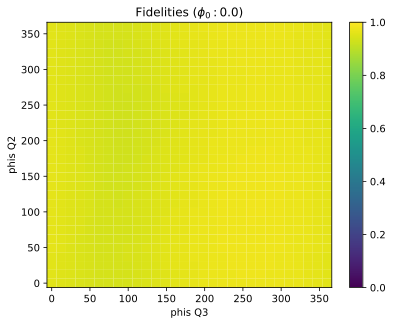

init state Q0 (switch) Q1 (input): |0>|0+1>
constructing final state on |switch, out1, out2>


  0%|          | 0/27000 [00:00<?, ?it/s]

Improved fidelity by (%) 43.34524656929599
(30, 30)
phi Q0 0.0


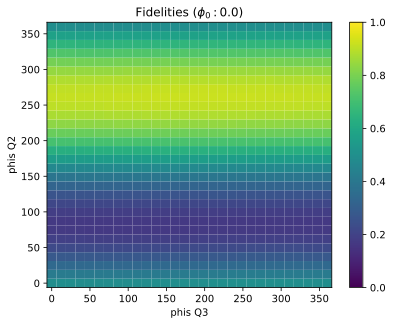

init state Q0 (switch) Q1 (input): |1>|0+1>
constructing final state on |switch, out1, out2>


  0%|          | 0/27000 [00:00<?, ?it/s]

Improved fidelity by (%) 67.54092655244742
(30, 30)
phi Q0 0.0


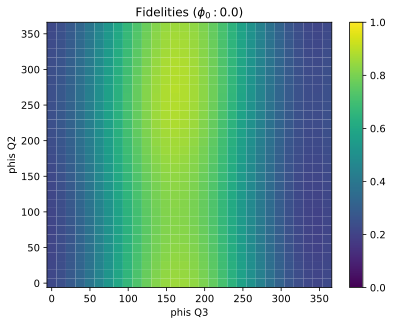

init state Q0 (switch) Q1 (input): |0+1>|1>
constructing final state on |switch, out1, out2>


  0%|          | 0/27000 [00:00<?, ?it/s]

Improved fidelity by (%) 7.5256615658000126
(30, 30)
phi Q0 0.0


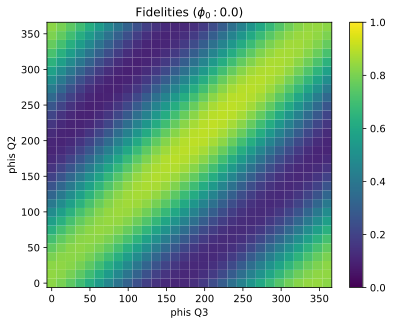

init state Q0 (switch) Q1 (input): |0+1>|0+1>
constructing final state on |switch, out1, out2>


  0%|          | 0/27000 [00:00<?, ?it/s]

Improved fidelity by (%) 77.1902353868791
(30, 30)
phi Q0 0.0


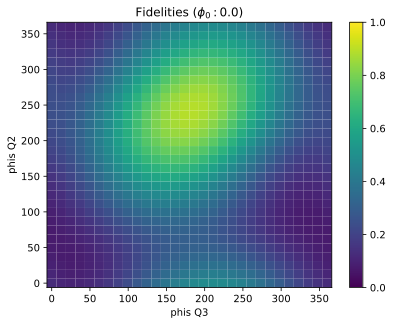

init state Q0 (switch) Q1 (input): |0>|0>
constructing final state on |switch, out1, out2>


  0%|          | 0/27000 [00:00<?, ?it/s]

Improved fidelity by (%) 0.677602442409897
(30, 30)
phi Q0 0.0


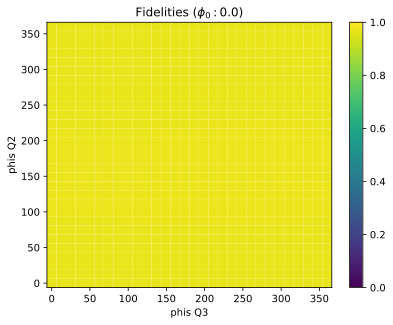

init state Q0 (switch) Q1 (input): |1>|0>
constructing final state on |switch, out1, out2>


  0%|          | 0/27000 [00:00<?, ?it/s]

Improved fidelity by (%) 1.7970534461786092
(30, 30)
phi Q0 0.0


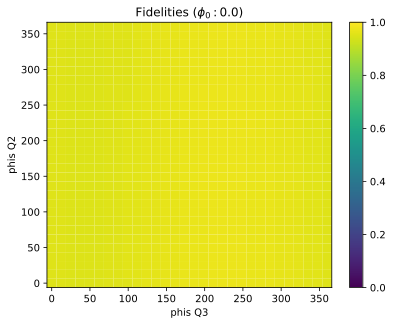

init state Q0 (switch) Q1 (input): |1>|1>
constructing final state on |switch, out1, out2>


  0%|          | 0/27000 [00:00<?, ?it/s]

Improved fidelity by (%) 6.494390673662142
(30, 30)
phi Q0 0.0


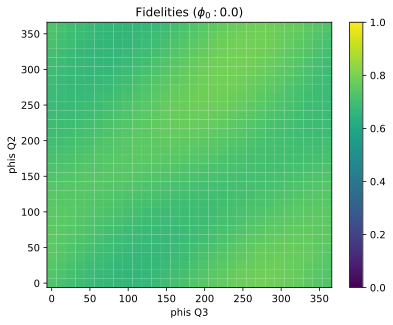

init state Q0 (switch) Q1 (input): |0>|1>
constructing final state on |switch, out1, out2>


  0%|          | 0/27000 [00:00<?, ?it/s]

Improved fidelity by (%) 1.335506721765367
(30, 30)
phi Q0 0.0


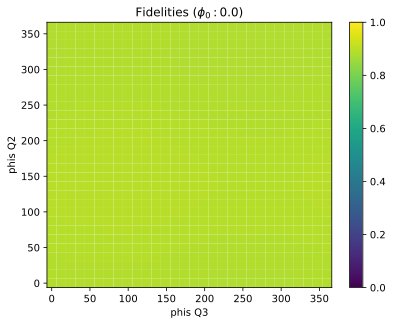

In [114]:
for i_saved_file, saved_file in enumerate(tqdm(saved_files)):
    init_state = init_states[i_saved_file]
    print('init state Q0 (switch) Q1 (input):', init_state)
    
    init_rho = rho_MLE_ZZ_dict[init_state]
    # init_rho = qt.ket2dm(name_to_state_2q(init_state)).full()
    rho_id = get_qram_qSLR_state_from_rho(init_rho)
    # ------------------------------ #
    # MLE with opt rot
    # ------------------------------ #
    rho_MLE_ZZ = rhos_ZZ[i_saved_file]
    rho_MLE = rho_MLE_ZZ
    
    phis[0] = np.linspace(0, 360, 30) # Q0
    phis[1] = np.linspace(0, 360, 30) # Q2
    phis[2] = np.linspace(0, 360, 30) # Q3
    if init_state == '|0+1>|0+1>' or init_state == '|0+1>|1>': phis[0] = np.linspace(0, 360, 30)
        
    rho_MLE_rot, best_phis, best_fid, fids_grid = tomo_analysis.opt_virtualZ_MLE(qt.Qobj(rho_MLE, dims=rho_id.dims), rho_id, phis=phis, progress=True)
    fids_grids.append(fids_grid)
    
    inner_sweep = phis[2]
    outer_sweep = phis[1]
    y_sweep = outer_sweep
    x_sweep = inner_sweep

    # vmax = np.max(fids_grid)
    vmax = 1.0
    # for i_phi0, phi0 in enumerate(phis[0]):
    for i_phi0, phi0 in enumerate([phis[0][0]]):
        print(fids_grid[i_phi0].shape)
        print(f'phi Q0 {phi0}')
        plt.figure()
        plt.title(f'Fidelities ($\phi_0: ${phi0:0.4})')
        plt.xlabel(f'phis Q{tomo_qubits[2]}')
        plt.ylabel(f'phis Q{tomo_qubits[1]}')
        plt.pcolormesh(x_sweep, y_sweep, fids_grid[i_phi0], cmap='viridis', shading='auto')
        plt.colorbar()
        plt.clim(vmin=0, vmax=vmax)
        plt.show()

    z_phi123 = tomo_analysis.z_gate_nq(best_phis)
    rho_MLE_rot = (z_phi123*qt.Qobj(rho_MLE, dims=rho_id.dims)*z_phi123.dag()).unit()
    fid_rot = qt.fidelity(rho_MLE_rot, rho_id)**2
    
    purity_MLE = np.real(np.trace(rho_MLE @ rho_MLE))
    purity_MLE_rot = np.real(np.trace(rho_MLE_rot.full() @ rho_MLE_rot.full()))
    purity_id = np.real(np.trace(rho_id.full() @ rho_id.full()))
    # print(f'Fidelity (after rotation): {fid_rot}')
    # print(f'Purity (after rotation): {purity_MLE_rot}')
    # print(f'Target purity: {purity_id}')
    # print(f'Best rotation: {best_phis}')
    
    # if saveplots: savetitle=saved_file[:-3]+f'_ZZcorrect_optrot{save_append}.svg'
    # else: savetitle = None
    # show_plot_rho_2d(rho_MLE_rot, rho_id, title=f'MLE with ZZ Correction, Phase Optimized (Q{tomo_qubits[0]}, Q{tomo_qubits[1]}, Q{tomo_qubits[2]}), Init {init_state}, Play {play_pulses}', savetitle=savetitle, cmax=0.5)
    
    fidelities_opt_rot.append(best_fid)
    all_best_phis.append(best_phis)
    
    # print('\n\n\n')

In [115]:
print(np.array(fids_grids).shape)
print(len(init_states))

(9, 30, 30, 30)
9


In [116]:
print('Input states', init_states)
print('Saved files', saved_files)
print('fidelities base MLE\n', fidelities_base)
print('ZZ correction fidelities\n', fidelities_ZZ)
# print('Optimal phi with base MLE fidelities\n', fidelities_opt_rot)
print('Optimal phi with ZZ correction fidelities\n', fidelities_opt_rot)
print('best_phis\n', all_best_phis)
print('purities (base MLE)\n', purities_base)
print('purities (ZZ correction)\n', purities_ZZ)

Input states ['|0+1>|0>', '|0>|0+1>', '|1>|0+1>', '|0+1>|1>', '|0+1>|0+1>', '|0>|0>', '|1>|0>', '|1>|1>', '|0>|1>']
Saved files ['S:\\QRAM\\qram_4QR2\\data\\data_241025\\00018_QramProtocol3QTomo.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_241025\\00019_QramProtocol3QTomo.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_241025\\00020_QramProtocol3QTomo.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_241025\\00021_QramProtocol3QTomo.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_241025\\00022_QramProtocol3QTomo.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_241025\\00023_QramProtocol3QTomo.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_241025\\00024_QramProtocol3QTomo.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_241025\\00025_QramProtocol3QTomo.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_241025\\00026_QramProtocol3QTomo.h5']
fidelities base MLE
 [0.9531268845182898, 0.4869935236966115, 0.22239567147746248, 0.7422657074613181, 0.07753221173146987, 0.9645511159853194, 0.9489464459499727, 0.7028725846012558, 0.8836593032713389]
ZZ correction fidelities
 [0

Go through the fids grids and select the best overall phi

In [117]:
check_init_states = init_states

(9, 30, 30, 30)
|0+1>|0>
best phi Q0 0.0


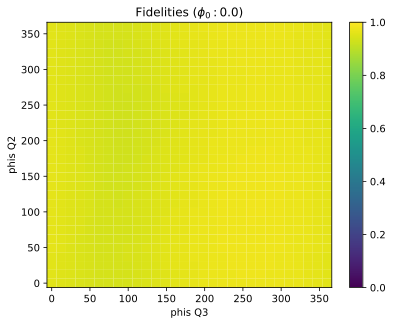

|0>|0+1>
best phi Q0 0.0


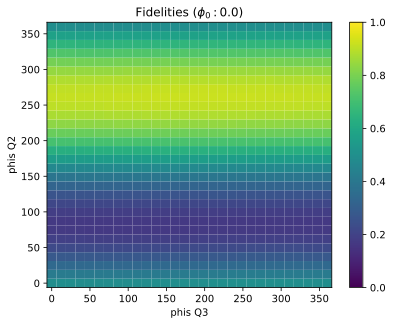

|1>|0+1>
best phi Q0 0.0


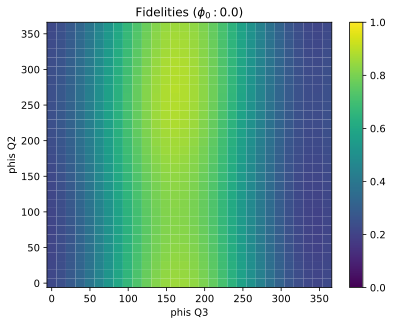

|0+1>|1>
best phi Q0 0.0


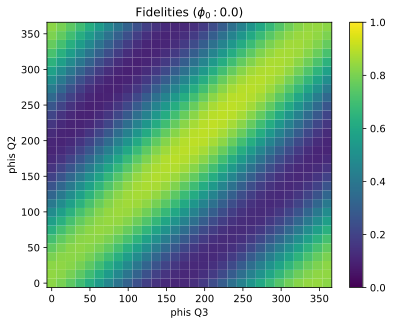

|0+1>|0+1>
best phi Q0 0.0


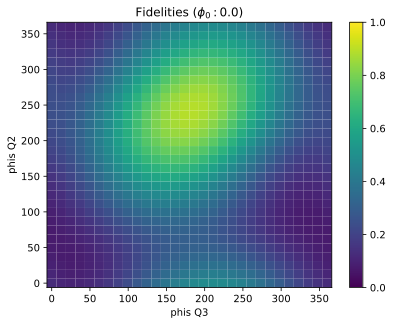

|0>|0>
best phi Q0 0.0


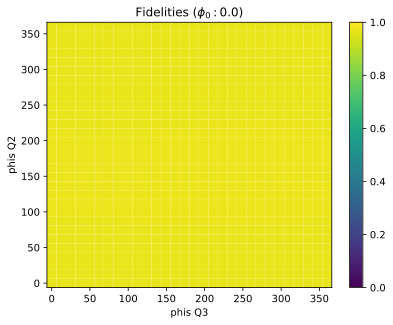

|1>|0>
best phi Q0 0.0


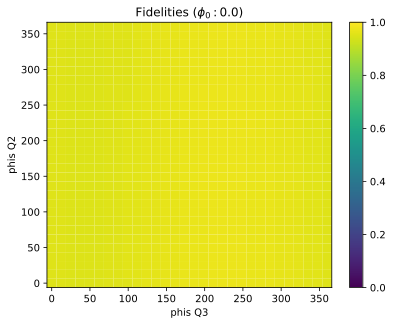

|1>|1>
best phi Q0 0.0


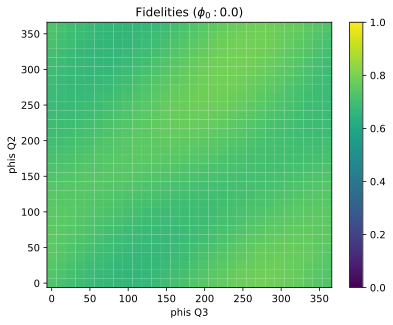

|0>|1>
best phi Q0 0.0


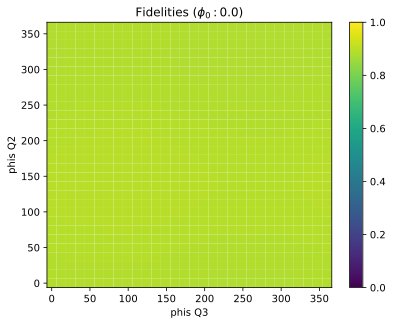

best avg fid 0.8886266396136633
best fids for check states [0.9568358943935681, 0.881961961953999, 0.8531174982129945, 0.8241013294949382, 0.8885123011041227, 0.9680662073064773, 0.9676489305553796, 0.7709918959078532, 0.8864037375936369]
best phis [0.0, 235.86206896551724, 186.20689655172413]


In [118]:
use_ZZ_mat = True

# Pick best overall phi

phis[0] = np.linspace(0, 360, 30) # Q0
# phis[0] = [0] # Q00
phis[1] = np.linspace(0, 360, 30) # Q2
phis[2] = np.linspace(0, 360, 30) # Q3

# check_init_states = ['|1>|0+1>', '|0>|0+1>', '|0+1>|1>', '|0+1>|0+1>', '|0+1>|0>']
# check_init_states = ['|1>|0+1>', '|0>|0+1>', '|0+1>|1>', '|0+1>|0+1>', '|0+1>|0>']
# check_init_states = ['|1>|0+1>', '|0>|0+1>', '|0+1>|1>', '|0+1>|0>', '|0+1>|0+1>']
# check_init_states = ['|1>|0+1>', '|0>|0+1>', '|0+1>|1>']
# check_init_states = ['|0+1>|0+1>']
    

fids_grids_reshaped = []
for i_state in range(len(init_states)):
    grid_shape = fids_grids[i_state].shape
    # print(grid_shape)
    fids_grid = np.copy(fids_grids[i_state]).tolist()
    # print(init_states[i_state], grid_shape)
    if grid_shape[0] == 1:
        for i in range(grid_shape[1]-1):
            fids_grid.append(fids_grid[0])
    # print(np.array(fids_grid).shape)
    fids_grids_reshaped.append(fids_grid)
    
fids_grids_reshaped = np.array(fids_grids_reshaped)
print(fids_grids_reshaped.shape)


best_avg_fid = 0
best_fids = []
best_phis = [0, 0, 0]
best_phi_indices = [0, 0, 0]
for iphi0, phi0 in enumerate(phis[0]):
    for iphi1, phi1 in enumerate(phis[1]):
        for iphi2, phi2 in enumerate(phis[2]):
            avg_fid = 0
            for i_state, init_state in enumerate(init_states):
                if init_state not in check_init_states: continue
                avg_fid += fids_grids_reshaped[i_state][iphi0, iphi1, iphi2]
            avg_fid /= len(check_init_states)
            if avg_fid > best_avg_fid:
                best_phis = [phi0, phi1, phi2]
                best_phi_indices = [iphi0, iphi1, iphi2]
                best_avg_fid = avg_fid
 
vmax = 1.0
for i_state in range(len(init_states)):
    print(init_states[i_state])
    print(f'best phi Q0 {best_phis[0]}')
    plt.figure()
    plt.title(f'Fidelities ($\phi_0: ${best_phis[0]:0.4})')
    plt.xlabel(f'phis Q{tomo_qubits[2]}')
    plt.ylabel(f'phis Q{tomo_qubits[1]}')
    plt.pcolormesh(x_sweep, y_sweep, fids_grids_reshaped[i_state, best_phi_indices[0], :, :], cmap='viridis', shading='auto')
    plt.colorbar()
    plt.clim(vmin=0, vmax=vmax)
    plt.show()


for i_state, init_state in enumerate(init_states):
    if init_state not in check_init_states: continue
    best_fids.append(fids_grids_reshaped[i_state][best_phi_indices[0], best_phi_indices[1], best_phi_indices[2]])

print('best avg fid', best_avg_fid)
print('best fids for check states', best_fids)
print('best phis', best_phis)

Plot all the tomos for the best phis

In [119]:
# best_phis = [360.0, 360.0, 235.86206896551724]
# best_phis = [0]*3

In [120]:
use_ZZ_mat = True
saveplots = False


init_state |0+1>|0>
constructing final state on |switch, out1, out2>
Fidelity (after rotation): 0.9568358943935681
Purity (after rotation): 0.8998119586664596
Target purity: 0.964493733510172


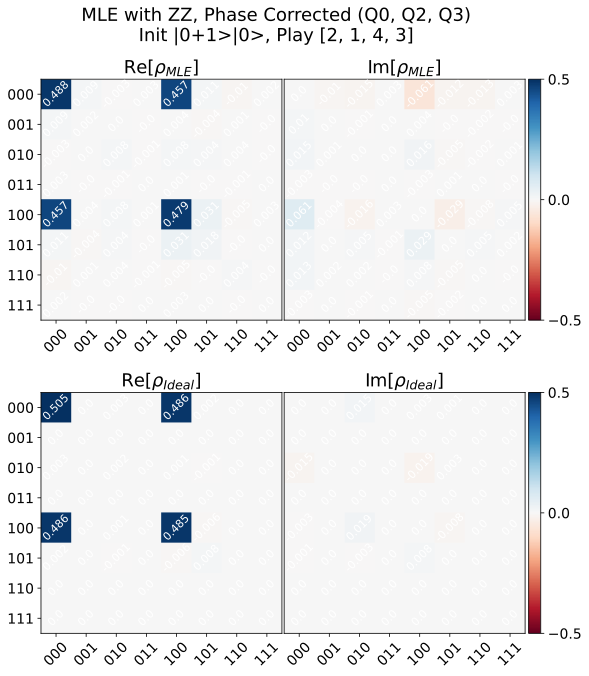


init_state |0>|0+1>
constructing final state on |switch, out1, out2>
Fidelity (after rotation): 0.881961961953999
Purity (after rotation): 0.7869476158839891
Target purity: 0.9266064962658728


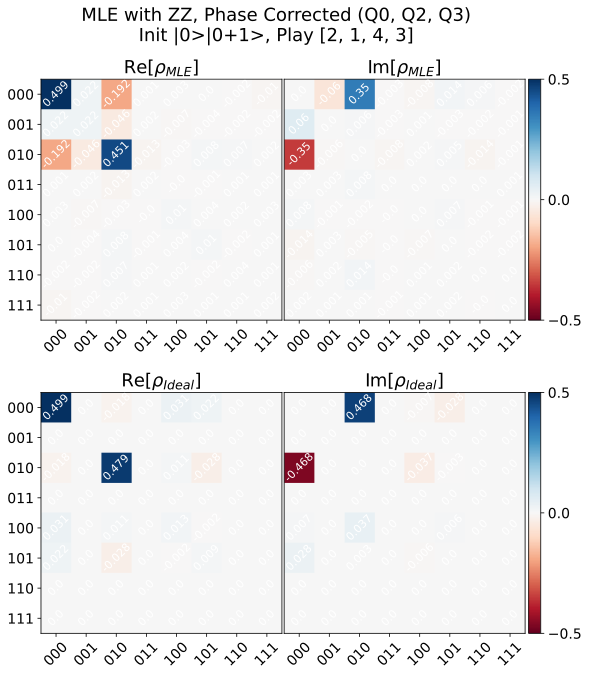


init_state |1>|0+1>
constructing final state on |switch, out1, out2>
Fidelity (after rotation): 0.8531174982129945
Purity (after rotation): 0.7676270406460575
Target purity: 0.8549581184360825


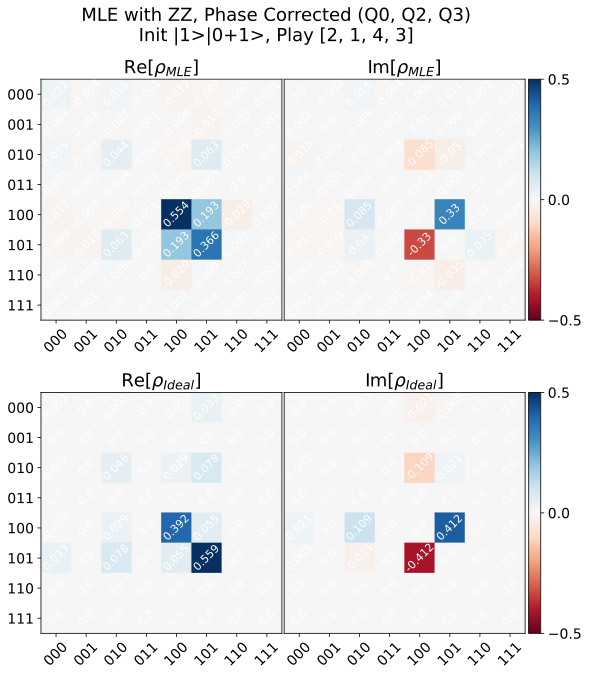


init_state |0+1>|1>
constructing final state on |switch, out1, out2>
Fidelity (after rotation): 0.8241013294949382
Purity (after rotation): 0.7247500752449308
Target purity: 0.9148368833376653


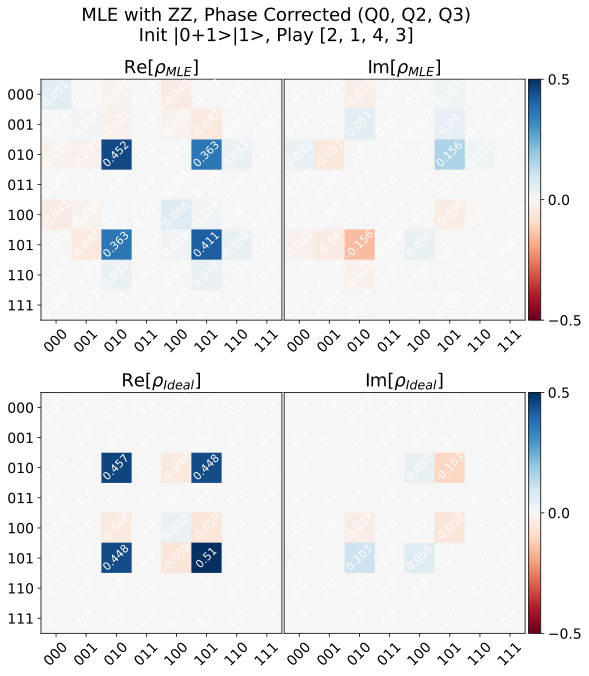


init_state |0+1>|0+1>
constructing final state on |switch, out1, out2>
Fidelity (after rotation): 0.8885123011041227
Purity (after rotation): 0.7521097007355866
Target purity: 0.9226417800814991


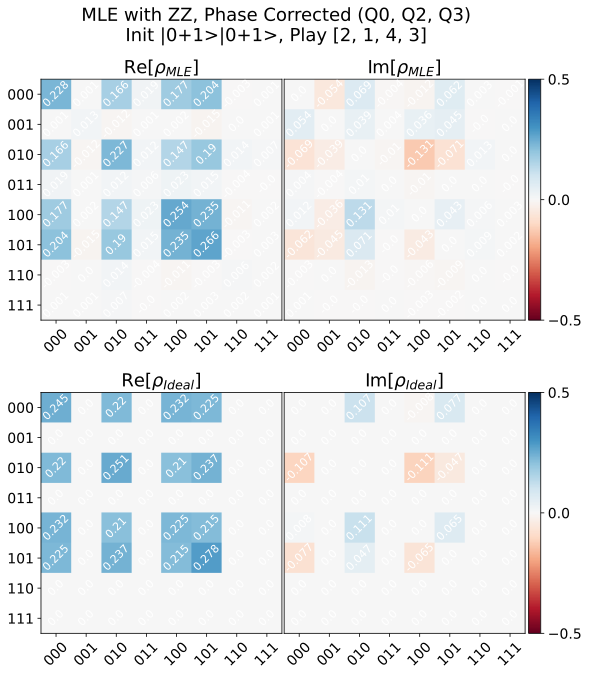


init_state |0>|0>
constructing final state on |switch, out1, out2>
Fidelity (after rotation): 0.9680662073064773
Purity (after rotation): 0.9187272396447658
Target purity: 0.9841225095421603


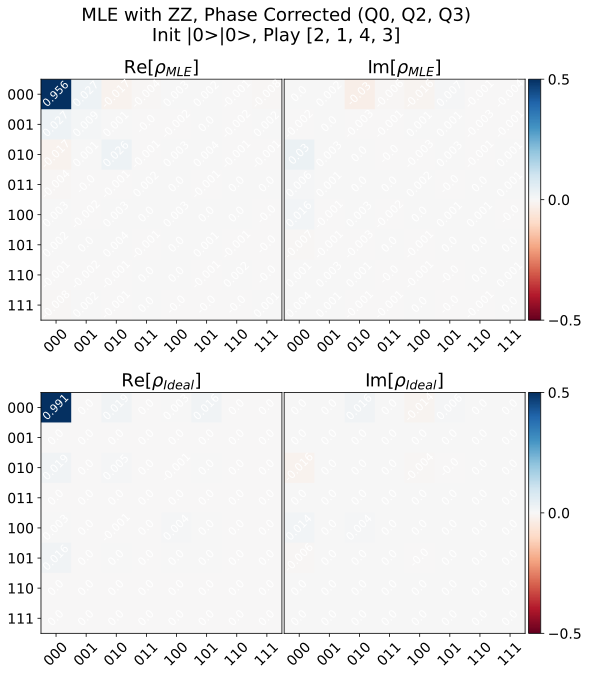


init_state |1>|0>
constructing final state on |switch, out1, out2>
Fidelity (after rotation): 0.9676489305553796
Purity (after rotation): 0.9360779862193337
Target purity: 0.9945000978708944


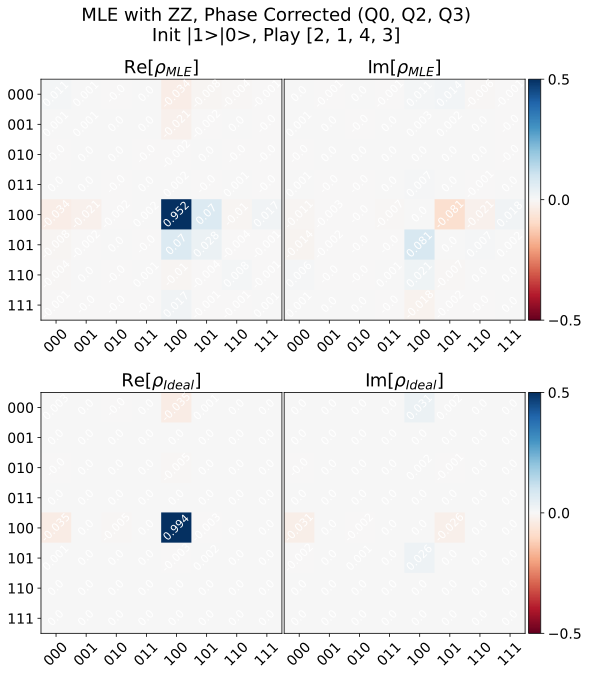


init_state |1>|1>
constructing final state on |switch, out1, out2>
Fidelity (after rotation): 0.7709918959078532
Purity (after rotation): 0.5865942396577524
Target purity: 0.9636052928779529


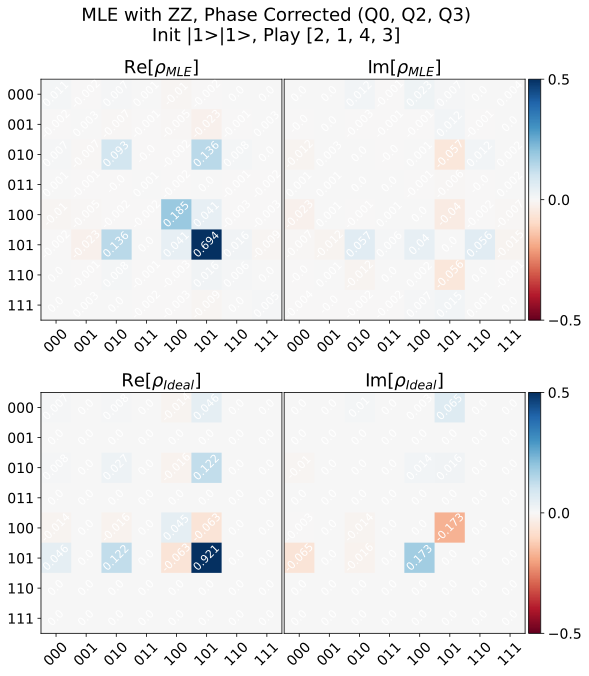


init_state |0>|1>
constructing final state on |switch, out1, out2>
Fidelity (after rotation): 0.8864037375936369
Purity (after rotation): 0.8264955404847677
Target purity: 0.9075847813684981


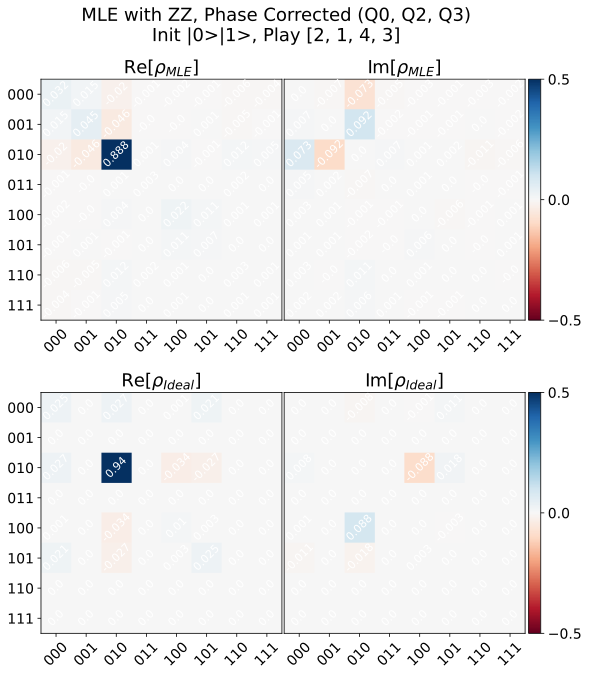


best fids
[0.9568358943935681, 0.881961961953999, 0.8531174982129945, 0.8241013294949382, 0.8885123011041227, 0.9680662073064773, 0.9676489305553796, 0.7709918959078532, 0.8864037375936369]
average best fid 0.8886266396136633
used best_phis [0.0, 235.86206896551724, 186.20689655172413]


In [121]:
z_phi123 = tomo_analysis.z_gate_nq(best_phis)
best_fids = []

print()
for i_state, init_state in enumerate(init_states):
    if init_state not in check_init_states: continue
    print('init_state', init_state)
    init_rho = rho_MLE_ZZ_dict[init_state]
    # init_rho = qt.ket2dm(name_to_state_2q(init_state)).full()
    rho_id = get_qram_qSLR_state_from_rho(init_rho)
    
    if use_ZZ_mat: rho_MLE_rot = (z_phi123*qt.Qobj(rhos_ZZ[i_state], dims=rho_id.dims)*z_phi123.dag()).unit()
    else: rho_MLE_rot = (z_phi123*qt.Qobj(rhos_base[i_state], dims=rho_id.dims)*z_phi123.dag()).unit()
    fid_rot = qt.fidelity(rho_MLE_rot, rho_id)**2
    best_fids.append(fid_rot)
    
    purity_MLE_rot = np.real(np.trace(rho_MLE_rot.full() @ rho_MLE_rot.full()))
    purity_id = np.real(np.trace(rho_id.full() @ rho_id.full()))
    print(f'Fidelity (after rotation): {fid_rot}')
    print(f'Purity (after rotation): {purity_MLE_rot}')
    print(f'Target purity: {purity_id}')
    
    if saveplots: savetitle=saved_file[:-3]+f'{"_ZZcorrect" if use_ZZ_mat else ""}_optrot{save_append}.svg'
    else: savetitle = None
    tomo_analysis.show_plot_rho_2d(rho_MLE_rot, rho_id, title=f'MLE {"with ZZ" if use_ZZ_mat else "Base"}, Phase Corrected (Q{tomo_qubits[0]}, Q{tomo_qubits[1]}, Q{tomo_qubits[2]})\nInit {init_state}, Play {play_pulses}', savetitle=savetitle, cmax=0.5)
    print()
print('best fids')
print(best_fids)
print('average best fid', np.average(best_fids))
print('used best_phis', best_phis)

## Run analysis

### Reopen old data

In [72]:
apply_ps = True
ps_adjust = [-0.3, -1.0, -0.3, -0.3]
# ps_adjust = [np.inf]*4
ps_qubits = [0, 1, 2, 3]

In [20]:
saved_files = []
filename = 'S:\\QRAM\\qram_4QR2\\data\\data_240617\\00075_QramProtocol3QTomo.h5'
# data, attrs = prev_data(expt_path, '00009_QramProtocol3QTomo.h5')
saved_files.append(filename)
data, attrs = prev_data(filename, None)
pulse_dict = attrs['pulse_dict']
print('calib_order', attrs['calib_order'])
print('meas_order', attrs['meas_order'])

print(data.keys())
# # data = None
# # style.use('default')
# # qramExpt.analyze(data=data)
# # qramExpt.display(data=data, err=False, saveplot=True)
# # print(data)

cfg = AttrDict(attrs['config'])
init_state = cfg.expt.init_state
play_pulses = cfg.expt.play_pulses
tomo_qubits = cfg.expt.tomo_qubits
print('init_state', init_state)
print('play_pulses', play_pulses)
print('tomo_qubits', tomo_qubits)

np.set_printoptions(suppress=True)
n_tomo_raw, n_calib = tomo_analysis.n_tomo_calib_from_data(data, cfg, ps_adjust=ps_adjust, ps_qubits=ps_qubits, apply_ps=apply_ps, verbose=True)
print('counts_calib')
n_calib = n_calib.astype(np.float64)
for r in range(n_calib.shape[0]):
    n_calib[r,:]/=np.sum(n_calib[r,:])
print(n_calib)
print(attrs['calib_order'])

print(f'thresholds={data["thresholds"].tolist()},')
print(f'angles={data["angles"].tolist()},')
print(f'ge_avgs={data["ge_avgs"].tolist()}',',')
print(f'counts_calib={data["counts_calib"].tolist()}')

S:\QRAM\qram_4QR2\data\data_240617\00075_QramProtocol3QTomo.h5


 C:\Users\slab\AppData\Local\Temp\ipykernel_13728\809401443.py: 13

Extracted data and attrs ['calib_order', 'config', 'meas_order', 'pulse_dict']
calib_order ['ggg', 'gge', 'geg', 'gee', 'egg', 'ege', 'eeg', 'eee']
meas_order ['ZZZ', 'ZZX', 'ZZY', 'ZXZ', 'ZXX', 'ZXY', 'ZYZ', 'ZYX', 'ZYY', 'XZZ', 'XZX', 'XZY', 'XXZ', 'XXX', 'XXY', 'XYZ', 'XYX', 'XYY', 'YZZ', 'YZX', 'YZY', 'YXZ', 'YXX', 'YXY', 'YYZ', 'YYX', 'YYY']
dict_keys(['angles', 'calib_ishots_raw', 'calib_qshots_raw', 'counts_calib', 'counts_raw', 'counts_tomo', 'epop', 'fpop', 'ge_avgs', 'gpop', 'ishots_raw', 'qshots_raw', 'thresholds', 'xpts'])
init_state |0+1>|1>
play_pulses [2, 1, 4, 3]
tomo_qubits [0, 2, 3]
ps thresholds [291.82897766 418.87927622 517.44076029  46.2649727 ]
new ps thresholds [241.35678152 293.93975267 447.51325372   6.71592663]
keep 27122 of 75000 shots (36.16266666666667 %)
keep 27122 of 75000 shots (36.16266666666667 %)
keep 27122 of 75000 shots (36.16266666666667 %)
ps thresholds [291.82897766 418.87927622 517.44076029  46.2649727 ]
new ps thresholds [241.35678152 293.9397

In [ ]:
# # counts_calib = data['counts_calib']
# counts_calib=[array([3189,  426, 3176,  519, 1176,  198, 1110,  206]), array([ 580, 3047,  582, 3015,  207, 1148,  221, 1200]), array([1963,  289, 4456,  583,  721,   97, 1661,  230]), array([ 390, 1850,  812, 4372,  130,  683,  269, 1494]), array([1336,  209, 1293,  232, 2954,  473, 2981,  522]), array([ 256, 1341,  226, 1320,  512, 2924,  557, 2864]), array([ 809,  118, 1892,  295, 1810,  262, 4215,  599]), array([ 167,  796,  352, 1830,  325, 1776,  781, 3973])]


# # introduce gaussian noise
# np.random.seed(0)
# noise = 2.0
# n = np.copy([counts_calib[4]])
# print(n, sum(n))
# n0 = correct_readout_err(n, n_conf=counts_calib)
# print('correct readout err', n0)
# print('fix neg counts', fix_neg_counts(n0))

# if noise is not None:
#     for n_psi in n:
#         n_meas = sum(n_psi)
#         new_nlast = -1
#         while new_nlast < 0:
#                 new_n_uptolast = np.random.normal(loc=n_psi[:-1], scale=noise*np.sqrt(n_psi[:-1]))
#                 # new_n_uptolast *= 1 - np.isnan(new_n_uptolast) # 0 out the nans
#                 # print('here', new_n_uptolast)
#                 # preserve original total count per measurement
#                 new_nlast = n_meas - sum(new_n_uptolast)
#                 n_psi[:-1] = np.round(new_n_uptolast)
#                 n_psi[-1] = np.round(new_nlast)

# print(1)
# print(n, sum(n))
# print(type(n))
# print(np.shape(n))
# print(n[0].dtype)
# n = np.array(n, dtype=float)
# n1 = correct_readout_err(n, n_conf=counts_calib)
# print('correct readout err', n1)
# print('fix neg counts', fix_neg_counts(n1))


# # print('n1-n2')
# # print(n1-n2)

# print(3)
# n = [[ 287, 1291,  675, 2954,  256, 1250,  554, 2733]]
# print(n)
# n = correct_readout_err(n, n_conf=counts_calib)
# print(sum(n))
# print(fix_neg_counts(n))

# print(4)
# correct_readout_err(counts_calib, counts_calib)

### Set ideal rho

Get ideal psi for fidelity calculation. Change this depending on what you want for ideal final state.

### Get final qram state from an arbitrary 2Q input density matrix

In [61]:
print('init state Q0 (switch) Q1 (input):', init_state)

# init_rho = qt.ket2dm(name_to_state_2q(init_state)).full()
# if init_state == '|0+1>|0+1>':
#     init_rho = np.array([[(0.23+0j), (0.057+0.233j), (0.18-0.099j), (-0.078+0.08j)], [(0.057-0.233j), (0.287+0j), (-0.016-0.171j), (-0.013+0.114j)], [(0.18+0.099j), (-0.016+0.171j), (0.266+0j), (-0.166+0.121j)], [(-0.078-0.08j), (-0.013-0.114j), (-0.166-0.121j), (0.217+0j)]])
# init_rho = qt.ket2dm((name_to_state_2q('|1>|0>') + name_to_state_2q('|1>|1>') + name_to_state_2q('|0>|0>') + 1j*name_to_state_2q('|0>|1>')).unit())

# rho_id = get_qram_qSLR_state_from_rho(init_rho)
# rho_id


# # rho_MLE_ZZ_2Q_filepath = 'S:\Connie\experiments\qramLL_4QR2\data\data_240218\\202402281619_init_rhoMLE_ZZ_2Q_01.npz'
# rho_MLE_ZZ_2Q_filepath = 'S:\Connie\experiments\qramLL_4QR2\data\data_240218\\202402291250_init_rhoMLE_ZZ_2Q_01.npz'

# print(f'Using rho_MLE_ZZ for Q0/Q1 from file {rho_MLE_ZZ_2Q_filepath}')

# rho_MLE_ZZ_dict = dict()
# with np.load(rho_MLE_ZZ_2Q_filepath) as npzfile:
#     for key in npzfile.keys():
#         rho_MLE_ZZ_dict.update({key:npzfile[key]})
# print(f'rho_MLE_ZZ retrieved with init_states {rho_MLE_ZZ_dict.keys()}')
init_rho = rho_MLE_ZZ_dict[init_state]
rho_id = get_qram_qSLR_state_from_rho(init_rho)

init state Q0 (switch) Q1 (input): |0>|1>
constructing final state on |switch, out1, out2>


In [88]:
# psi_id = qt.tensor(psiZ[1]+psiZ[0], psiZ[0], psiZ[1]+psiZ[0]).unit()
# psi_id = qt.tensor(psiZ[1], psiZ[0], psiZ[1]).unit()
# rho_id = qt.ket2dm(psi_id)
# rho_id = qt.ket2dm(psis['010'] + psis['011']).unit()
rho_id = qt.ket2dm(psis['010']).unit()
# print(rho_id.dims)

### Generate test data

In [ ]:
# rho_id = qt.ket2dm(psi10 + psi11).unit()

# n_tomo = generate_counts(rho_id=rho_id, n_tot=8000, noise=None)
n_tomo_sim = generate_counts(rho_id=rho_id, n_tot=100000, evol_mats=evol_mats, noise=None)
# n_tomo = generate_counts(rho_id=rho_MLE_ZZ, n_tot=100000, evol_mats=evol_mats, noise=None)
# n_tomo = n_tomo_sim
print(n_tomo_sim)

print(meas_order)
print(calib_order)
print('difference')
print(np.round((n_tomo_sim - n_tomo)/100000, 2))

In [ ]:
# n_tomo = generate_counts(rho_id=rho_id, n_tot=8000, noise=None)
# n_tomo = generate_counts(rho_id=rho_id, n_tot=8000, evol_mats=evol_mats, noise=None)
# n_calib = qt.qeye(4).full()
# print(fix_neg_counts(n_tomo))

### Run MLE without ZZ correction

In [155]:
# methods = 'Nelder-Mead' 'Powell' 'CG' 'BFGS' 'Newton-CG' 'L-BFGS-B' 'TNC' 'COBYLA' 'SLSQP' 'dogleg' 'trust-ncg'
# rho_MLE_base = run_MLE(n=n_tomo, rho_id=rho_id, ZZ_correction=False, method='L-BFGS-B')
rho_MLE_base = tomo_analysis.get_rho_from_counts(
    n_tomo_raw=n_tomo_raw,
    n_calib=n_calib,
    correct_readout=True,
    correct_neg_counts=True,
    method='analytical',
    ZZ_correction=False,
)

print(rho_MLE_base)

[[ 0.02977909+0.j         -0.00397974-0.00093391j -0.00135111-0.00048677j
   0.00041421+0.00116623j -0.01469723+0.00816138j  0.00534773+0.02920598j
   0.00201421+0.00120773j  0.00125141+0.00223413j]
 [-0.00397974+0.00093391j  0.00725183+0.j          0.00039415+0.00094411j
   0.00031345+0.00014624j -0.01200877+0.00064929j -0.00458346+0.00766711j
  -0.00583649+0.00089608j -0.00059678-0.00276376j]
 [-0.00135111+0.00048677j  0.00039415-0.00094411j  0.00326836+0.j
   0.00027392-0.00031511j -0.00347405+0.00110501j -0.00390293+0.00036131j
   0.0007444 +0.00061308j -0.00068202+0.0000858j ]
 [ 0.00041421-0.00116623j  0.00031345-0.00014624j  0.00027392+0.00031511j
   0.00278766+0.j         -0.00485581-0.0025482j   0.00299751-0.00564059j
   0.00003895+0.0010996j  -0.00074552+0.00098928j]
 [-0.01469723-0.00816138j -0.01200877-0.00064929j -0.00347405-0.00110501j
  -0.00485581+0.0025482j   0.06804836-0.j          0.02860712+0.01108196j
   0.00269275-0.00184104j -0.00060915+0.0022547j ]
 [ 0.00534773

Fidelity (no ZZ correction): 0.0032683580062633573
Purity (no ZZ correction): 0.7813633736630816
[[ 0.03 +0.j    -0.004-0.001j -0.001-0.j     0.   +0.001j -0.015+0.008j
   0.005+0.029j  0.002+0.001j  0.001+0.002j]
 [-0.004+0.001j  0.007+0.j     0.   +0.001j  0.   +0.j    -0.012+0.001j
  -0.005+0.008j -0.006+0.001j -0.001-0.003j]
 [-0.001+0.j     0.   -0.001j  0.003+0.j     0.   -0.j    -0.003+0.001j
  -0.004+0.j     0.001+0.001j -0.001+0.j   ]
 [ 0.   -0.001j  0.   -0.j     0.   +0.j     0.003+0.j    -0.005-0.003j
   0.003-0.006j  0.   +0.001j -0.001+0.001j]
 [-0.015-0.008j -0.012-0.001j -0.003-0.001j -0.005+0.003j  0.068-0.j
   0.029+0.011j  0.003-0.002j -0.001+0.002j]
 [ 0.005-0.029j -0.005-0.008j -0.004-0.j     0.003+0.006j  0.029-0.011j
   0.878+0.j    -0.001-0.003j  0.002+0.002j]
 [ 0.002-0.001j -0.006-0.001j  0.001-0.001j  0.   -0.001j  0.003+0.002j
  -0.001+0.003j  0.009+0.j     0.   +0.002j]
 [ 0.001-0.002j -0.001+0.003j -0.001-0.j    -0.001-0.001j -0.001-0.002j
   0.002-0.002j

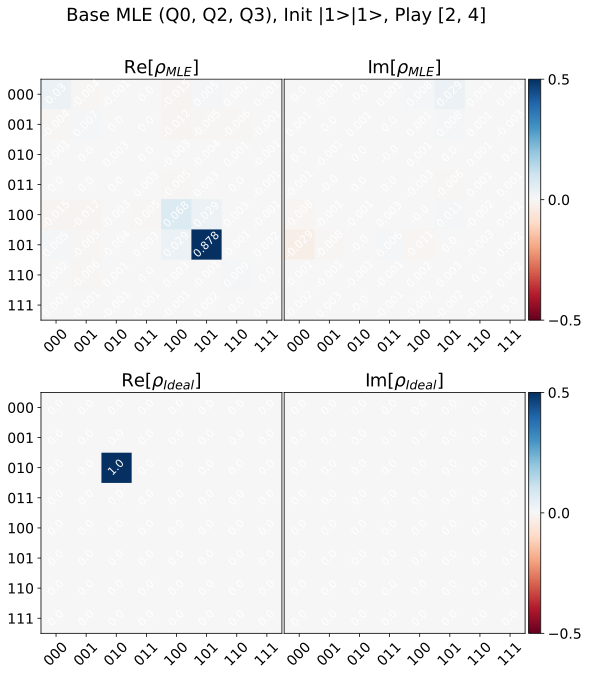

Saved data:



In [156]:
fid_base = qt.fidelity(qt.Qobj(rho_MLE_base, dims=rho_id.dims), rho_id)**2 # qutip uses N&C fidelity which is "sqrt fidelity"
purity_base = np.real(np.trace(rho_MLE_base @ rho_MLE_base))
print(f'Fidelity (no ZZ correction): {fid_base}')
print(f'Purity (no ZZ correction): {purity_base}')
print(np.around(rho_MLE_base, decimals=3))
tomo_analysis.show_plot_rho_2d(rho_MLE_base, rho_id, title=f'Base MLE (Q{tomo_qubits[0]}, Q{tomo_qubits[1]}, Q{tomo_qubits[2]}), Init {init_state}, Play {play_pulses}', cmax=0.5)

print('Saved data:')
print(*saved_files)

### Run MLE with ZZ

#### Get evol mats for ZZ

In [ ]:
# Recover old config
# yaml_cfg = AttrDict(attrs['config'])

In [49]:
import yaml
with open(config_path, 'r') as cfg_file:
    yaml_cfg = yaml.safe_load(cfg_file)
yaml_cfg = AttrDict(yaml_cfg)

In [22]:
# evol_mats_path = os.path.join(os.getcwd(), 'evol_mats')
evol_mats_path = "S:\\QRAM\\qram_4QR2\\evol_mats"
print('Will save evol mats to path', evol_mats_path)

qA, qB, qC = tomo_qubits
# evol_mats_filename = f'evol_mats_{qA}{qB}{qC}.npz'
evol_mats_filename = f'evol_mats_{qA}{qB}{qC}_old.npz'
print('Will save to filename', evol_mats_filename)

Will save evol mats to path S:\QRAM\qram_4QR2\evol_mats
Will save to filename evol_mats_023_old.npz


In [136]:
evol_mats = tomo_analysis.get_evol_mats_from_yaml(
    tomo_qubits=tomo_qubits,
    yaml_cfg=yaml_cfg,
    pulse_dict=pulse_dict,
    cutoffs=[4]*(len(tomo_qubits)),
    soccfg=soc,
    debug=False,
    evol_mats_path=evol_mats_path,
    evol_mats_filename=evol_mats_filename,
)

TOMO QUBITS [0, 2, 3]
HAMILTONIAN QUBITS [0 2 3]
qubit freqs [4110.42824795 4762.20157232 4381.6795443 ]
alphas [-226.05445455 -189.80621679 -171.69840356]
ZZs (MHz) [[ 0.         -0.22967106 -0.55809684]
 [-0.1408671   0.         -0.52353906]
 [-0.53768634 -0.53692257  0.        ]]
Will save to filename evol_mats_023_old.npz


  0%|          | 0/27 [00:00<?, ?it/s]

Saved evol mats to file S:\QRAM\qram_4QR2\evol_mats\evol_mats_023_old.npz


#### Reload evol mats

In [23]:
qA, qB, qC = tomo_qubits
evol_mats_file_path = os.path.join(evol_mats_path, evol_mats_filename)
# evol_mats_file_path = os.path.join(evol_mats_path, f'evol_mats_{qA}{qB}{qC}_test.npz')
print(f'Using evol mats from file {evol_mats_file_path}')

evol_mats = dict()
with np.load(evol_mats_file_path) as npzfile:
    for key in npzfile.keys():
        evol_mats.update({key:npzfile[key]})
# print(evol_mats)

Using evol mats from file S:\QRAM\qram_4QR2\evol_mats\evol_mats_023_old.npz


#### (Actually) run MLE with ZZ correction

In [24]:
rho_MLE_ZZ = tomo_analysis.get_rho_from_counts(
    n_tomo_raw=n_tomo_raw,
    n_calib=n_calib,
    correct_readout=True,
    correct_neg_counts=True,
    method='analytical',
    ZZ_correction=True,
    evol_mats=evol_mats
)

 S:\Connie\experiments\qram_tprocv1_expts\TomoAnalysis.py: 1220ComplexWarning: Casting complex values to real discards the imaginary part
 S:\Connie\experiments\qram_tprocv1_expts\TomoAnalysis.py: 1225

In [25]:
# GET IDEAL RHO FROM DICTIONARY
print('init state to get ideal rho', init_state)
init_rho = rho_MLE_ZZ_dict[init_state]
rho_id = get_qram_qSLR_state_from_rho(init_rho)

init state to get ideal rho |0+1>|1>
constructing final state on |switch, out1, out2>


In [30]:
print(np.around(rho_MLE_ZZ, decimals=3))
fid_ZZ = qt.fidelity(qt.Qobj(rho_MLE_ZZ, dims=rho_id.dims), rho_id)**2 # qutip uses N&C fidelity which is "sqrt fidelity"
purity_ZZ = np.real(np.trace(rho_MLE_ZZ @ rho_MLE_ZZ))
purity_id = np.real(np.trace(rho_id.full() @ rho_id.full()))
print(f'Fidelity (with ZZ correction): {fid_ZZ}')
print(f'Purity (with ZZ correction): {purity_ZZ}')
print(f'Target purity: {purity_id}')
# savetitle = '1_0+1_ideal.png'
# savetitle = 'test.png'
savetitle=None

if savetitle is None: plt.style.use('default')
# show_plot_rho_2d(rho_id, rho_id, title='MLE with ZZ Correction', savetitle=savetitle) #, cmax=1.0)
print('init state', init_state)
tomo_analysis.show_plot_rho_2d(rho_MLE_ZZ, rho_id, title=f'MLE with ZZ Correction (Q{tomo_qubits[0]}, Q{tomo_qubits[1]}, Q{tomo_qubits[2]}), Init {init_state}, Play {play_pulses}', savetitle=savetitle, cmax=0.5)

if save_data:
    print('Saved data:')
    print(saved_files[-1])

[[ 0.017+0.j    -0.002+0.002j -0.017+0.01j   0.   +0.003j -0.003+0.009j
  -0.01 +0.007j  0.001+0.001j -0.003-0.002j]
 [-0.002-0.002j  0.013+0.j    -0.017-0.015j  0.   +0.j     0.   -0.002j
  -0.007+0.028j -0.002+0.001j -0.001+0.j   ]
 [-0.017-0.01j  -0.017+0.015j  0.541-0.j     0.015-0.011j -0.008+0.001j
  -0.218-0.244j  0.014-0.008j -0.001-0.002j]
 [ 0.   -0.003j  0.   -0.j     0.015+0.011j  0.004+0.j    -0.003+0.002j
  -0.004-0.j     0.003-0.002j -0.001-0.001j]
 [-0.003-0.009j  0.   +0.002j -0.008-0.001j -0.003-0.002j  0.02 +0.j
  -0.014+0.01j  -0.003+0.001j -0.001+0.007j]
 [-0.01 -0.007j -0.007-0.028j -0.218+0.244j -0.004+0.j    -0.014-0.01j
   0.398-0.j    -0.009-0.003j  0.009-0.008j]
 [ 0.001-0.001j -0.002-0.001j  0.014+0.008j  0.003+0.002j -0.003-0.001j
  -0.009+0.003j  0.004+0.j     0.001-0.j   ]
 [-0.003+0.002j -0.001-0.j    -0.001+0.002j -0.001+0.001j -0.001-0.007j
   0.009+0.008j  0.001+0.j     0.003+0.j   ]]
Fidelity (with ZZ correction): 0.3906747661867258
Purity (with ZZ c

### Optimize over virtual Z gates on ideal rho 

Optimize over virtual Z gates on ideal rho 

In [68]:
# rho_MLE = rho_MLE_base
rho_MLE = rho_MLE_ZZ

In [69]:
phis = [None, None, None]
phis[0] = np.linspace(0, 360, 40)
phis[1] = np.linspace(0, 360, 40)
phis[2] = np.linspace(0, 360, 40)
# phis[0] = np.linspace(0, 360, 1)
# phis[1] = np.linspace(0, 360, 100)
# phis[2] = np.linspace(0, 360, 100)

rho_MLE_rot, best_phis, best_fid, fids_grid = opt_virtualZ_MLE(qt.Qobj(rho_MLE, dims=rho_id.dims), rho_id, phis=phis)
print('Rotation:', best_phis)

Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
 C:\Users\slab\AppData\Local\Temp\ipykernel_2540\425015463.py: 13

  0%|          | 0/40 [00:00<?, ?it/s]

Improved fidelity by (%) 11.465662672047639
Rotation: [101.53846153846153, 286.15384615384613, 221.53846153846152]


phi Q0 101.53846153846153
fid at phi2=286.15384615384613, phi3=221.53846153846152: 0.9156225067163491
Saved S:\Connie\experiments\qramLL_4QR2\data\data_240617\00033_QramProtocol3QTomo.svg


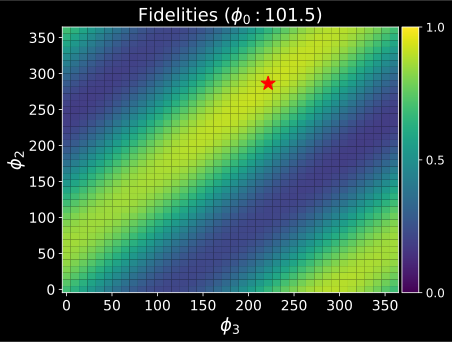

In [70]:
inner_sweep = phis[2]
outer_sweep = phis[1]
y_sweep = outer_sweep
x_sweep = inner_sweep

# vmax = np.max(fids_grid)
vmax = 1.0

# best_phis =  [350.7692307692307, 304.6153846153846, 138.46153846153845]
# best_phis =  [115, 350, 203]
# best_phis = [350.7692307692307, 18.46153846153846, 258.46153846153845]

saveplot = True
plot_filename = filename[:-3]+'.svg'
if saveplot: plt.style.use('dark_background')
best_phi_inds = [np.argmin(np.abs(phis[i]-best_phis[i])) for i in range(3)]

for i_phi0, phi0 in enumerate(phis[0]):
    if i_phi0 != best_phi_inds[0]: continue 
    print(f'phi Q0 {phi0}')
    plt.figure()
    plt.title(f'Fidelities ($\phi_0: ${phi0:0.4})', fontsize=18)
    plt.xlabel(f'$\phi_{tomo_qubits[2]}$', fontsize=18)
    plt.xticks(fontsize=14)
    plt.ylabel(f'$\phi_{tomo_qubits[1]}$', fontsize=18)
    plt.yticks(fontsize=14)
    plt.pcolormesh(y_sweep, x_sweep, fids_grid[i_phi0], cmap='viridis', shading='auto')
    
    plt.plot([best_phis[2]], [best_phis[1]], 'r', marker='*', markersize=15)
    print(f'fid at phi2={best_phis[1]}, phi3={best_phis[2]}:', fids_grid[i_phi0][best_phi_inds[1]][best_phi_inds[2]])
    
    # old_best_phis = [0.0, 94.54545454545455, 349.09090909090907]
    # old_best_phis = [0.0, 196.36363636363635, 341.8181818181818]
    # plt.plot([old_best_phis[2]], [old_best_phis[1]], 'r', marker='o')
    
    divider = make_axes_locatable(plt.gca())
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = plt.colorbar(cax=cax, ticks=[0, 0.5, vmax])
    # cbar.ax.set_title(f'Fidelity')
    cbar.ax.tick_params(labelsize=12)
    plt.clim(vmin=0, vmax=vmax)
    
    if saveplot:
        plt.savefig(plot_filename, format='svg', bbox_inches='tight', transparent=True)
        print('Saved', plot_filename)
        
    plt.show()
    
# print(f'Difference between phi0[0] and phi0[1]')
# plt.figure()
# plt.title(f'Difference in fidelities ($\phi_0: $0 vs 30)')
# plt.xlabel(f'phis Q{tomo_qubits[2]}')
# plt.ylabel(f'phis Q{tomo_qubits[1]}')
# plt.pcolormesh(y_sweep, x_sweep, fids_grid[0]-fids_grid[1], cmap='viridis', shading='auto')

# # plt.plot([best_phis[2]], [best_phis[1]], 'r', marker='o')

# # old_best_phis = [0.0, 94.54545454545455, 349.09090909090907]
# # old_best_phis = [0.0, 196.36363636363635, 341.8181818181818]
# # plt.plot([old_best_phis[2]], [old_best_phis[1]], 'r', marker='o')

# plt.colorbar()
# # plt.clim(vmin=0, vmax=1)
# plt.show()

In [43]:
best_phis = [360.0, 360.0, 235.86206896551724]
# best_phis = old_best_phis

# rho_MLE = rho_MLE_ZZ

z_phi123 = tomo_analysis.z_gate_nq(best_phis)
rho_MLE_rot = (z_phi123*qt.Qobj(rho_MLE, dims=rho_id.dims)*z_phi123.dag()).unit()
fid_rot = qt.fidelity(rho_MLE_rot, rho_id)**2

purity_MLE = np.real(np.trace(rho_MLE @ rho_MLE))
purity_MLE_rot = np.real(np.trace(rho_MLE_rot.full() @ rho_MLE_rot.full()))
purity_id = np.real(np.trace(rho_id.full() @ rho_id.full()))
print(f'Fidelity (after rotation): {fid_rot}')
print(f'Purity (after rotation): {purity_MLE_rot}')
print(f'Target purity: {purity_id}')
print(f'Best rotation: {best_phis}')

# print(np.around(rho_MLE_rot, decimals=3))
savetitle=None
# savetitle=saved_file[:-3]+f'_ZZcorrect_optrot.svg'
tomo_analysis.show_plot_rho_2d(rho_MLE_rot, rho_id, title=f'MLE with ZZ Correction, Phase Optimized (Q{tomo_qubits[0]}, Q{tomo_qubits[1]}, Q{tomo_qubits[2]})', savetitle=savetitle, cmax=0.5)
print('Saved data')
print(saved_files[-1])

Fidelity (after rotation): 0.8767109811538215
Purity (after rotation): 0.6725160736309431
Target purity: 0.8620525724713737
Best rotation: [360.0, 360.0, 235.86206896551724]
Saved data
S:\QRAM\qram_4QR2\data\data_240617\00075_QramProtocol3QTomo.h5


# Loop over 2Q sweep parameters

In [ ]:
# gain_sweep = np.linspace(2000, 25000, 11)
# opt_lens = 1e3*np.array([2.4201237152470587, 1.1987019004033739, 0.7868408797215013, 0.5851160587684981, 0.4716335769416996, 0.3999234927074055, 0.34781134410506404, 0.3089041362621608, 0.2818412962269934, 0.2636215545192442, 0.2512183319921639])
# opt_freqs = [5891.5, 5891.325, 5890.9, 5890.35, 5889.675, 5888.875, 5887.95, 5887.15, 5886.1, 5885.55, 5884.5]


gain_sweep = np.linspace(18000, 32000, 11)
opt_freqs = [5887.35, 5886.616666666667, 5885.883333333333, 5885.616666666667, 5885.116666666667, 5884.383333333333, 5884.116666666667, 5883.616666666667, 5882.883333333333, 5882.383333333333, 5882.583333333333]
opt_lens = [0.30514258121790533, 0.28952631508344284, 0.27703044436306967, 0.2646698856191053, 0.25368901625658447, 0.24735611563570364, 0.23874769989670325, 0.23044507614293083, 0.22816368954972915, 0.22170985331767395, 0.20962837376879714]

save_data = True
sweep2Q_q = 2
qubit = 2
play_pulses=[1,3]

In [ ]:
saved_files = []

init_state = '|0+1>|1>'

opt_phis = [None]

thresholds = None
angles = None
ge_avgs = None
counts_calib = None


for i_gain, gain in enumerate(gain_sweep):
    
    tomo = meas.QramProtocol3QTomoExperiment(
        soccfg=soc,
        path=expt_path,
        config_file=config_path,
    )
    
    span = np.inf
    npts = 1
    if span < np.inf: print('time step size [cycles]:', soc.us2cycles(span/npts))
    
    tomo.cfg.expt = dict(
        start=span,
        step=0,
        expts=1, # number of different time experiments
        reps=30000, # number of reps per tomo/time step,
        singleshot_reps=30000, # reps per state for singleshot calibration
        post_process='scale', # 'threshold', (uses single shot binning), 'scale' (scale by ge_avgs), or None
        tomo_3q=True,
        tomo_qubits=tomo_qubits,
        init_state=init_state,
        play_pulses=play_pulses,
        thresholds=thresholds,
        angles=angles,
        ge_avgs=ge_avgs,
        counts_calib=counts_calib,
    )
    tomo.cfg.device.qubit.pulses.pi_EgGf_Q.gain[sweep2Q_q] = int(gain)
    tomo.cfg.device.qubit.pulses.pi_EgGf_Q.sigma[sweep2Q_q] = opt_lens[i_gain]
    tomo.cfg.device.qubit.f_EgGf_Q[sweep2Q_q] = opt_freqs[i_gain]
    print('gain', tomo.cfg.device.qubit.pulses.pi_EgGf_Q.gain[sweep2Q_q],
          'len', tomo.cfg.device.qubit.pulses.pi_EgGf_Q.sigma[sweep2Q_q],
          'freq', tomo.cfg.device.qubit.f_EgGf_Q[sweep2Q_q])
    try:
        tomo.go(analyze=False, display=False, progress=False, save=False)
    except Exception:
        print("Pyro traceback:")
        print("".join(Pyro4.util.getPyroTraceback()))
    
    if save_data: saved_files.append(tomo.save_data())
    data = tomo.data
    if i_gain == 0:
        thresholds = data['thresholds']
        angles = data['angles']
        ge_avgs = data['ge_avgs']
        counts_calib = data['counts_calib']
    
    print()

In [ ]:
print(saved_files)

In [ ]:
print(saved_files)

### Calculate fidelities with ZZ correction and phase optimization

In [ ]:
apply_ps = True
ps_adjust = [-0.3, -1.0, -0.3, -0.3]
# ps_adjust = [np.inf]*4
ps_qubits = [0, 1, 2, 3]

In [ ]:
all_n_tomo = []
all_n_calib = []
all_fids = []
all_fids_rot = []

rho_id = qt.ket2dm(psis['001'] + psis['110']).unit()

for saved_file in saved_files:
    saved_file = saved_file.split('\\')
    # print(saved_file)
    data, attrs = prev_data(expt_path, saved_file[-1])
    pulse_dict = attrs['pulse_dict']
    cfg = AttrDict(attrs['config'])
    
    n_tomo_raw, n_calib = tomo_analysis.n_tomo_calib_from_data(data, cfg, ps_adjust=ps_adjust, ps_qubits=ps_qubits, apply_ps=apply_ps, verbose=True)

    all_n_tomo.append(n_tomo_raw)
    all_n_calib.append(n_calib)

    rho_MLE = tomo_analysis.get_rho_from_counts(
        n_tomo_raw=n_tomo_raw,
        n_calib=n_calib,
        correct_readout=True,
        correct_neg_counts=True,
        method='analytical',
        ZZ_correction=True,
        evol_mats=evol_mats,
    )
    
    # show_plot_rho_2d(rho_MLE_ZZ, rho_id, title=f'MLE with ZZ Correction (Q{tomo_qubits[0]}, Q{tomo_qubits[1]}, Q{tomo_qubits[2]})', savetitle=savetitle, cmax=0.5)
    fid_base = qt.fidelity(qt.Qobj(rho_MLE, dims=rho_id.dims), rho_id)**2 # qutip uses N&C fidelity which is "sqrt fidelity"

    all_fids.append(fid_base)
    print('fid base', fid_base)
    
    rho_MLE_rot, best_phis, fid_rot = opt_virtualZ_MLE(qt.Qobj(rho_MLE, dims=rho_id.dims), rho_id, phis=phis)
    all_fids_rot.append(fid_rot)
    tomo_analysis.show_plot_rho_2d(rho_MLE_rot, rho_id, title=f'MLE with ZZ Correction, Phase Optimized (Q{tomo_qubits[0]}, Q{tomo_qubits[1]}, Q{tomo_qubits[2]})', savetitle=None, cmax=0.5)
    print('fid rot', fid_rot)
    


In [ ]:
# print(all_n_tomo)
# print(all_n_calib)
# print(all_fids)
print('fidelity with optimized rotation\n', all_fids_rot)
print('saved files\n', saved_files)

In [ ]:
plt.plot(opt_lens, all_fids_rot, label='Q2 measured fidelity')

# decay_time = 10e3 # ns
# max_fid_times = np.linspace(0, max(opt_lens), 100)
# max_fids = np.exp(-max_fid_times/decay_time)
# plt.plot(max_fid_times, max_fids, '--', label=f'{decay_time/1e3} us decay')

# decay_time = 1e3 # ns
# max_fid_times = np.linspace(0, max(opt_lens), 100)
# max_fids = np.exp(-max_fid_times/decay_time)
# plt.plot(max_fid_times, max_fids, '--', label=f'{decay_time/1e3} us decay')

plt.xlabel(f'Length of 2Q swap in full protocol (ns)')
plt.ylabel(f'Q{sweep2Q_q} Fidelity')
plt.title(f'Q{sweep2Q_q}/Q1 parameter sweep from initial state {init_state}')
plt.legend()
plt.show()